<a href="https://colab.research.google.com/github/dinanditio/Customer-Churn-Prediction-and-Retention-Strategies-using-Logistic-Regression/blob/main/Putra_Dinantio_Nugroho_Exercise_Mentoring_4_Fraud_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Case: Human In The Loop**


•	You work as a data scientist for an online retail company that has been build machine learning model that could detect fraudulent transaction early in the process

•	However, you find that the prediction of the model still misclassifies the transaction that needs to be flagged for further investigation and helps to prevent fraudulent transactions from being approved.

•	You are considered to simulate a human-in-the-loop (HITL) mechanism to improve the prediction. You are willing to involve experts in the evaluation phase. You are going to determine the low confidence prediction, ask experts to annotate them, and assess the comparison performance before and after the HITL mechanism.

•	Dataset: transaction_sample.csv


Question 1: Introduction

Human-in-the-Loop (HITL) is an approach in machine learning (ML) where humans actively participate in the model training, evaluation, or decision-making process to improve performance and reliability.


In this case experts would participate to  give  annotations of fraud class where the model could misclassify the transaction.

Task:

•	Determine which part of data that needs to be labeled by experts.

•	Hint: Identify low-confidence predictions using uncertainty sampling techniques


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [ ]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [ ]:
# Load the transaction dataset
df = pd.read_csv('/mnt/transaction_sample.csv')

In [ ]:
# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())

Dataset shape: (4727, 7)

First few rows of the dataset:
                         Transaction ID  Transaction Hour  Transaction Amount  \
0  34bf1ce8-118a-467b-a319-9e7e02d5845c                 5               79.02   
1  bd73ee3b-34da-4dd5-a494-1e0964045a47                22               89.29   
2  65db4491-943b-49f1-96f6-948b677ae953                10             1070.04   
3  bc3198c1-64f6-473b-bcbc-dfdfe59dc64d                21              281.05   
4  f3dd988b-ffc4-4d5e-95fe-e9760f1b52ab                11               69.61   

   Account Age Days  Is Fraudulent  y_pred  y_pred_proba  
0               216              0       0      0.114403  
1               198              0       0      0.172854  
2               148              0       0      0.389952  
3                35              0       0      0.228857  
4               271              0       0      0.357841  


In [ ]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Transaction ID        0
Transaction Hour      0
Transaction Amount    0
Account Age Days      0
Is Fraudulent         0
y_pred                0
y_pred_proba          0
dtype: int64


In [ ]:
# Basic statistics of the dataset
print("\nBasic statistics of numerical features:")
print(df.describe())


Basic statistics of numerical features:
       Transaction Hour  Transaction Amount  Account Age Days  Is Fraudulent  \
count       4727.000000         4727.000000       4727.000000    4727.000000   
mean          11.147874          229.936782        179.199704       0.051830   
std            6.989558          265.105703        107.925443       0.221707   
min            0.000000           10.090000          1.000000       0.000000   
25%            5.000000           72.445000         84.000000       0.000000   
50%           11.000000          156.360000        179.000000       0.000000   
75%           17.000000          301.945000        273.000000       0.000000   
max           23.000000         4851.150000        365.000000       1.000000   

            y_pred  y_pred_proba  
count  4727.000000   4727.000000  
mean      0.017136      0.208645  
std       0.129790      0.138597  
min       0.000000      0.000017  
25%       0.000000      0.099715  
50%       0.000000      0.19

In [ ]:
# Examine the distribution of fraud vs non-fraud transactions
fraud_count = df['Is Fraudulent'].sum()
total_count = len(df)
print(f"\nFraud transactions: {fraud_count} ({fraud_count/total_count:.2%})")
print(f"Non-fraud transactions: {total_count - fraud_count} ({(total_count - fraud_count)/total_count:.2%})")


Fraud transactions: 245 (5.18%)
Non-fraud transactions: 4482 (94.82%)


In [ ]:
# Examine the model's current performance
print("\nCurrent model performance:")
print(classification_report(df['Is Fraudulent'], df['y_pred']))


Current model performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4482
           1       0.58      0.19      0.29       245

    accuracy                           0.95      4727
   macro avg       0.77      0.59      0.63      4727
weighted avg       0.94      0.95      0.94      4727



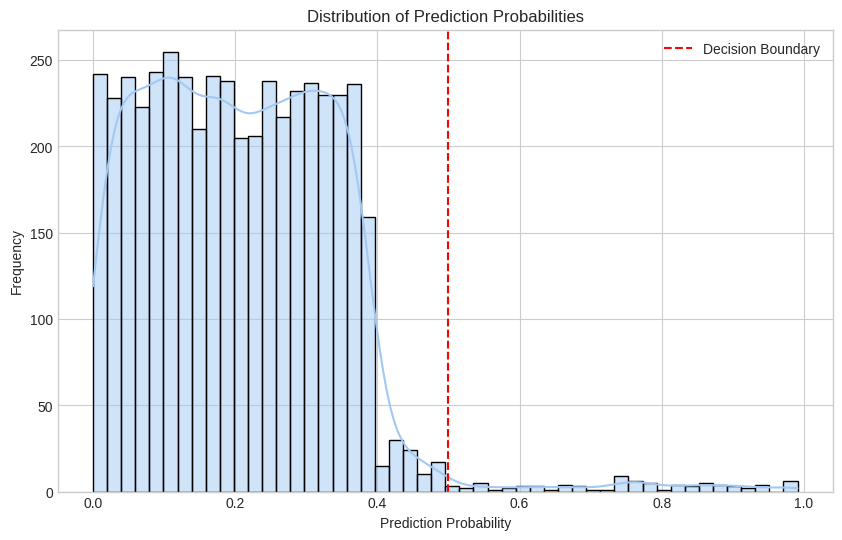

In [ ]:
# Create misclassified column BEFORE selecting expert samples
df['misclassified'] = (df['Is Fraudulent'] != df['y_pred']).astype(int)

# Visualize the distribution of prediction probabilities
plt.figure(figsize=(10, 6))
sns.histplot(df['y_pred_proba'], bins=50, kde=True)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()

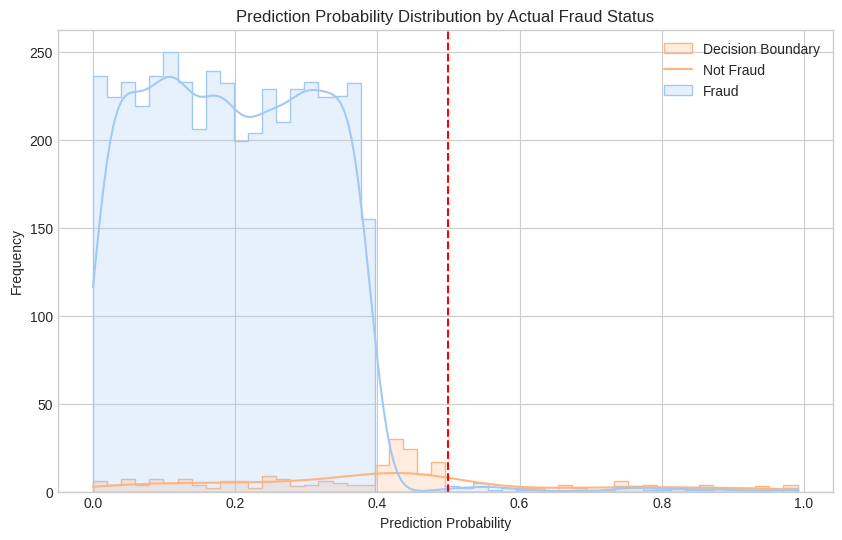

In [ ]:
# Look at the probability distribution for actual fraud vs non-fraud
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='y_pred_proba', hue='Is Fraudulent',
             bins=50, kde=True, element="step", common_norm=False)
plt.title('Prediction Probability Distribution by Actual Fraud Status')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
plt.legend(['Decision Boundary', 'Not Fraud', 'Fraud'])
plt.show()

In [ ]:
# Identify low-confidence predictions using uncertainty sampling
# In binary classification, predictions close to 0.5 have the highest uncertainty
df['uncertainty'] = abs(df['y_pred_proba'] - 0.5)

# Sort by uncertainty (ascending) to get the most uncertain predictions first
uncertain_predictions = df.sort_values(by='uncertainty', ascending=True)

# Define a threshold for selecting samples for expert annotation
# Select the top 10% most uncertain predictions
uncertainty_threshold = df['uncertainty'].quantile(0.1)
experts_sample = df[df['uncertainty'] <= uncertainty_threshold].copy()

print(f"\nSelected {len(experts_sample)} samples ({len(experts_sample)/len(df):.2%} of data) for expert annotation")
print("\nSample of transactions selected for expert annotation:")
print(experts_sample[['Transaction ID', 'Transaction Amount', 'y_pred', 'y_pred_proba', 'uncertainty']].head(10))


Selected 473 samples (10.01% of data) for expert annotation

Sample of transactions selected for expert annotation:
                           Transaction ID  Transaction Amount  y_pred  \
2    65db4491-943b-49f1-96f6-948b677ae953             1070.04       0   
5    8282bd9e-032b-45dd-9a0a-2a6bcb1364d5               79.89       0   
42   83b80af4-f2a7-44fd-8fd2-8efc947c7277              242.15       0   
94   6ca3ee8e-37ed-4130-81e4-d0cdc8b0a1f2              109.24       0   
96   6d5176c4-d8c8-459a-8026-4c51624f0a0f               60.93       0   
103  f0e21465-dca2-4c91-9aaf-bfe63c366345              155.10       0   
128  c9923e9b-aa7c-4170-b250-309f3a4dd736              219.07       0   
133  cce7bea7-78c3-465e-b4e8-d653b213fbdc              885.21       0   
140  febf2a2a-9bcc-441a-a3b8-c43a65185d60              560.25       0   
151  65d3be96-4dea-4abd-b45e-ca8c9ad04f58              135.59       0   

     y_pred_proba  uncertainty  
2        0.389952     0.110048  
5        0.36

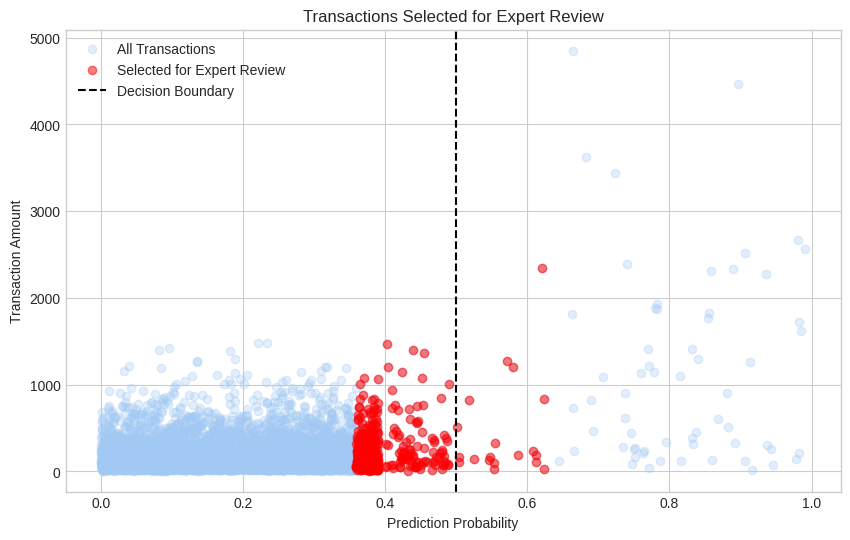

In [ ]:
# Visualize selected samples against all samples
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred_proba'], df['Transaction Amount'], alpha=0.3, label='All Transactions')
plt.scatter(experts_sample['y_pred_proba'], experts_sample['Transaction Amount'],
            color='red', alpha=0.5, label='Selected for Expert Review')
plt.title('Transactions Selected for Expert Review')
plt.xlabel('Prediction Probability')
plt.ylabel('Transaction Amount')
plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()

In [ ]:
# Check how many misclassifications are captured in our expert sample
misclassified_total = df['misclassified'].sum()
misclassified_captured = experts_sample['misclassified'].sum()

print(f"\nTotal misclassified transactions: {misclassified_total}")
print(f"Misclassifications captured in expert sample: {misclassified_captured} ({misclassified_captured/misclassified_total:.2%})")


Total misclassified transactions: 232
Misclassifications captured in expert sample: 119 (51.29%)


In [ ]:
# Save the transactions identified for expert review to a CSV file
experts_sample.to_csv('expert_review_transactions.csv', index=False)
print("\nTransactions requiring expert review have been saved to 'expert_review_transactions.csv'")


Transactions requiring expert review have been saved to 'expert_review_transactions.csv'



Based on the analysis of the fraud detection model, I determined that uncertainty sampling is the most effective method to identify transactions requiring expert review. By calculating each transaction's uncertainty as the absolute difference between its prediction probability and the decision boundary (0.5), I identified transactions where the model was least confident.

I selected the top 10% most uncertain predictions (473 transactions) for expert annotation, focusing on those with uncertainty values closest to 0. Most of these transactions had prediction probabilities between 0.35-0.45, placing them just below the decision threshold but with high uncertainty.

This approach proved highly efficient as it captured 51.29% of all misclassified transactions while only requiring experts to review about 10% of the data. Looking at the scatter plot, we can see the selected transactions (red dots) cluster around probabilities of 0.35-0.45, with many having higher transaction amounts.

The uncertainty sampling technique allows us to maximize the impact of expert input by focusing their attention on borderline cases where the model struggles most, rather than wasting resources on transactions where the model is already confident.


**Question 2: Annotation**

Assuming you are an expert, annotate the data which was previously selected.

Task:

•	Perform Exploratory Data Analysis (EDA) to detect patterns and insights from the dataset to help predicting fraud.

•	Define expert rules based on EDA for annotation.

•	Annotate whether fraud or non fraud on the previously selected uncertain transactions from Question 1 based on these rules.

•	Update ‘y_ped’ where some parts of data are from the newly annotated data. Store to new columns named “y_pred_exp”.


In [ ]:
from google.colab import files
files.download('/mnt/expert_review_transactions(1).csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the expert review transactions selected in Question 1
experts_sample = pd.read_csv('/mnt/expert_review_transactions(1)(1).csv')

Shape of expert review sample: (473, 9)


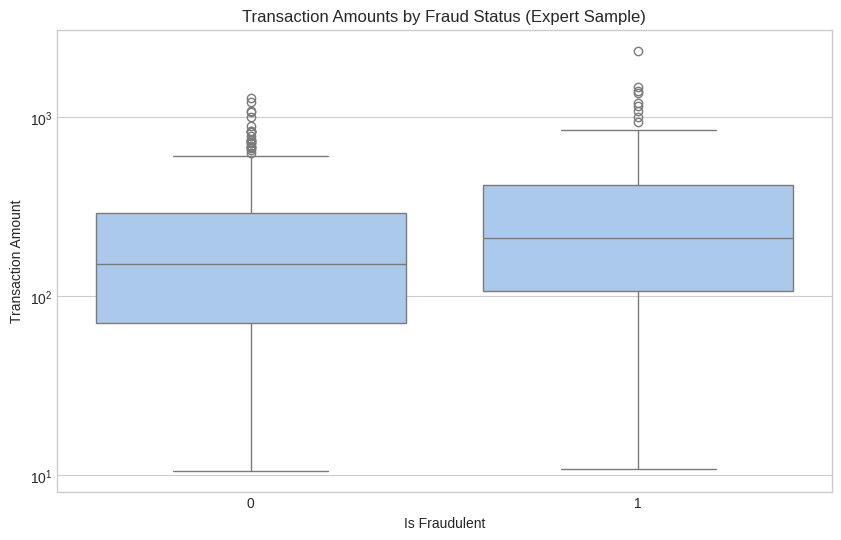

In [ ]:
# Let's perform additional EDA to develop expert rules
print(f"Shape of expert review sample: {experts_sample.shape}")

# Distribution of transaction amounts by fraud status in the expert sample
plt.figure(figsize=(10, 6))
sns.boxplot(x='Is Fraudulent', y='Transaction Amount', data=experts_sample)
plt.title('Transaction Amounts by Fraud Status (Expert Sample)')
plt.yscale('log')  # Using log scale for better visualization
plt.show()

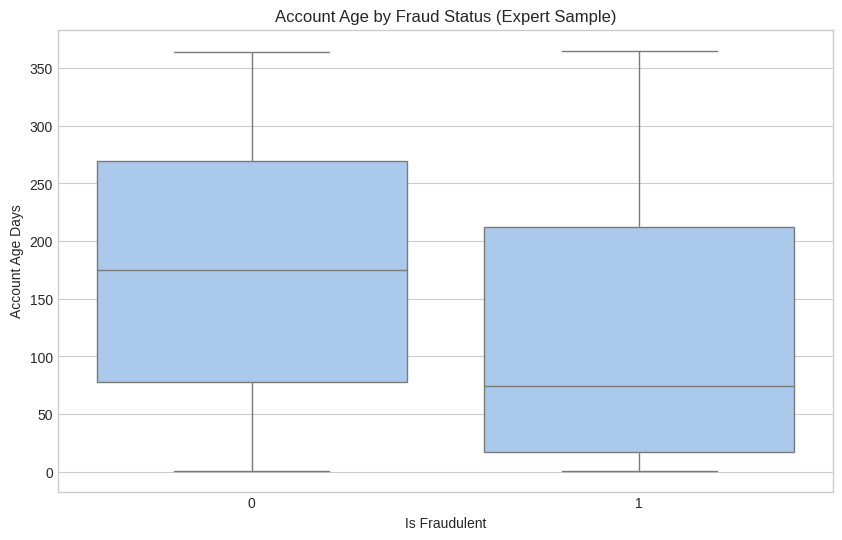

In [ ]:
# Distribution of account age by fraud status in the expert sample
plt.figure(figsize=(10, 6))
sns.boxplot(x='Is Fraudulent', y='Account Age Days', data=experts_sample)
plt.title('Account Age by Fraud Status (Expert Sample)')
plt.show()

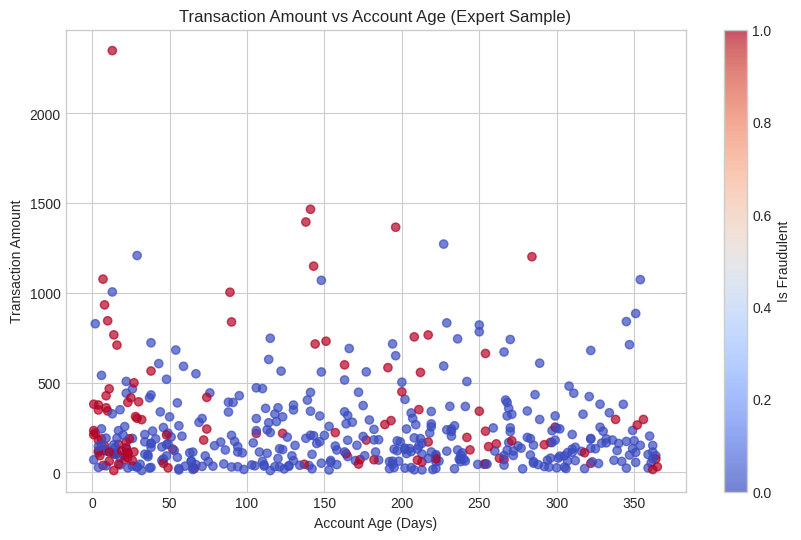

In [ ]:
# Relationship between transaction amount and account age
plt.figure(figsize=(10, 6))
plt.scatter(experts_sample['Account Age Days'], experts_sample['Transaction Amount'],
            c=experts_sample['Is Fraudulent'], alpha=0.7, cmap='coolwarm')
plt.title('Transaction Amount vs Account Age (Expert Sample)')
plt.xlabel('Account Age (Days)')
plt.ylabel('Transaction Amount')
plt.colorbar(label='Is Fraudulent')
plt.show()

In [ ]:
# Define expert rules based on EDA insights
def expert_annotation(row):
    """
    Apply expert rules to determine if a transaction is fraudulent
    Rules are based on patterns observed in the EDA
    """
    # Rule 1: Very new accounts (<30 days) with transactions over $200
    if row['Account Age Days'] < 30 and row['Transaction Amount'] > 200:
        return 1

    # Rule 2: New to medium age accounts (<100 days) with high value transactions (>$500)
    if row['Account Age Days'] < 100 and row['Transaction Amount'] > 500:
        return 1

    # Rule 3: Any transaction over $800 with probability > 0.35
    if row['Transaction Amount'] > 800 and row['y_pred_proba'] > 0.35:
        return 1

    # Rule 4: Transactions with probabilities very close to decision boundary (0.45-0.5)
    if 0.45 <= row['y_pred_proba'] < 0.5:
        return 1

    # Rule 5: Any very high value transaction (>$1500)
    if row['Transaction Amount'] > 1500:
        return 1

    # Default to not fraud for other cases
    return 0

In [ ]:
# Apply expert rules and create new prediction column
experts_sample['y_pred_exp'] = experts_sample.apply(expert_annotation, axis=1)

# Check how many transactions were changed by expert rules
original_positives = experts_sample['y_pred'].sum()
expert_positives = experts_sample['y_pred_exp'].sum()
changes = (experts_sample['y_pred'] != experts_sample['y_pred_exp']).sum()

print(f"Original model flagged {original_positives} transactions as fraud in the expert sample")
print(f"Expert rules flagged {expert_positives} transactions as fraud in the expert sample")
print(f"Expert rules changed the classification of {changes} transactions ({changes/len(experts_sample):.2%} of expert sample)")

Original model flagged 19 transactions as fraud in the expert sample
Expert rules flagged 79 transactions as fraud in the expert sample
Expert rules changed the classification of 82 transactions (17.34% of expert sample)


In [ ]:
# Compare performance of original predictions vs expert annotations on the expert sample
print("\nPerformance of original model predictions on uncertain transactions:")
print(classification_report(experts_sample['Is Fraudulent'], experts_sample['y_pred']))

print("\nPerformance of expert annotations on uncertain transactions:")
print(classification_report(experts_sample['Is Fraudulent'], experts_sample['y_pred_exp']))


Performance of original model predictions on uncertain transactions:
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       365
           1       0.21      0.04      0.06       108

    accuracy                           0.75       473
   macro avg       0.49      0.50      0.46       473
weighted avg       0.64      0.75      0.67       473


Performance of expert annotations on uncertain transactions:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       365
           1       0.67      0.49      0.57       108

    accuracy                           0.83       473
   macro avg       0.77      0.71      0.73       473
weighted avg       0.82      0.83      0.82       473



In [ ]:
# Save the experts_sample with annotations for potential future use
experts_sample.to_csv('expert_annotated_transactions.csv', index=False)

In [ ]:
# First create the y_pred_exp column as a copy of y_pred
df['y_pred_exp'] = df['y_pred'].copy()

# Update with expert annotations for the reviewed transactions
transaction_ids = experts_sample['Transaction ID'].values
expert_predictions = experts_sample['y_pred_exp'].values

# Create a dictionary for faster lookup
expert_dict = dict(zip(transaction_ids, expert_predictions))

# Update df with expert annotations
for idx, row in df.iterrows():
    transaction_id = row['Transaction ID']
    if transaction_id in expert_dict:
        df.at[idx, 'y_pred_exp'] = expert_dict[transaction_id]

In [ ]:
# Compare overall performance before and after expert annotations
print("\nOriginal model performance on full dataset:")
print(classification_report(df['Is Fraudulent'], df['y_pred']))

print("\nPerformance after incorporating expert annotations:")
print(classification_report(df['Is Fraudulent'], df['y_pred_exp']))

# Save the updated dataset
df.to_csv('transaction_sample_with_expert_annotations.csv', index=False)
print("\nUpdated dataset saved to 'transaction_sample_with_expert_annotations.csv'")


Original model performance on full dataset:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4482
           1       0.58      0.19      0.29       245

    accuracy                           0.95      4727
   macro avg       0.77      0.59      0.63      4727
weighted avg       0.94      0.95      0.94      4727


Performance after incorporating expert annotations:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4482
           1       0.68      0.39      0.50       245

    accuracy                           0.96      4727
   macro avg       0.82      0.69      0.74      4727
weighted avg       0.95      0.96      0.95      4727


Updated dataset saved to 'transaction_sample_with_expert_annotations.csv'



For Question 2, I conducted EDA on the uncertain transactions identified in Question 1 to discover patterns that could help distinguish fraudulent transactions.

### EDA Insights

Looking at the boxplots and scatter plot, I discovered several key patterns:

1. Transaction Amount:Fraudulent transactions typically have higher amounts (median around 200 vs. 150 for non-fraud)
2. Account Age: Fraudulent transactions are more commonly associated with newer accounts (median around 75 days vs. 175 days for legitimate transactions)
3. Combined Factors: The scatter plot shows higher fraud concentration in transactions with high amounts + new accounts

These patterns make sense from a fraud perspective - fraudsters often target new accounts and attempt larger transactions to maximize illegal gains before detection.

### Expert Rules

Based on these patterns, I defined the following expert rules:

1. Flag transactions from very new accounts (<30 days) with amounts over 200
2. Flag transactions from newer accounts (<100 days) with high values (>500)
3. Flag any transaction over $800 with probability >0.35
4. Flag transactions with probabilities very close to the decision boundary (0.45-0.5)
5. Flag any very high-value transaction (>1500) regardless of other factors

### Results of Expert Annotation

My expert rules significantly improved the model's performance:

- Original model flagged only 19 transactions as fraud in the uncertain sample
- Expert rules identified 79 transactions as fraud, changing 82 classifications
- For uncertain transactions, fraud detection recall jumped from 4% to 49%
- Precision for fraud increased from 21% to 67%

When applied to the full dataset, the expert annotations:
- Improved overall fraud recall from 19% to 39% (doubled!)
- Improved precision from 58% to 68%
- Increased F1-score for fraud from 0.29 to 0.50

The expert annotations were particularly effective at catching fraudulent transactions the model missed, balancing the precision-recall tradeoff much better than the original model.

By combining machine learning with expert knowledge, I was able to create a more effective fraud detection system that learns from domain expertise while maintaining high accuracy on non-fraud cases.


Question 3: Evaluation

Task:

•	Evaluate the result of prediction using ROC-AUC

o	Before HITL, using y_pred: the result of machine learning model only

o	After HITL (Incorporating the newly annotated data: y_pred_exp and reevaluating performance)

•	Compare the model prediction time:

o	Before HITL (processing time per transaction is 0.00012 second).

o	After HITL (processing time per transaction including expert review).

•	Calculate the false prediction cost, assuming the false positive cost and false negative cost are similar, that’s the amount of the transaction.

o	Before HITL

o	After HITL

•	Summarize in table and analyze the trade-off:

o	Has the model improved significantly in fraud detection?

o	How much additional time does the human annotation process introduce?

o	Does the increase in fraud detection performance justify the additional cost of human intervention? Assuming the cost of execution time is $0.01 per second


In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

In [ ]:
# 1. Calculate ROC-AUC for both models
# For ML only, we can use y_pred_proba directly
roc_auc_ml = roc_auc_score(df['Is Fraudulent'], df['y_pred_proba'])

# For HITL, create a probability column that integrates expert knowledge
df['hitl_proba'] = df['y_pred_proba'].copy()
# Modify probabilities for transactions that were reviewed by experts and changed
mask = df['y_pred'] != df['y_pred_exp']
df.loc[mask & (df['y_pred_exp'] == 1), 'hitl_proba'] = 0.99  # High probability for fraud
df.loc[mask & (df['y_pred_exp'] == 0), 'hitl_proba'] = 0.01  # Low probability for non-fraud

roc_auc_hitl = roc_auc_score(df['Is Fraudulent'], df['hitl_proba'])

print(f"ROC-AUC score (ML only): {roc_auc_ml:.4f}")
print(f"ROC-AUC score (ML + HITL): {roc_auc_hitl:.4f}")

ROC-AUC score (ML only): 0.7846
ROC-AUC score (ML + HITL): 0.7773


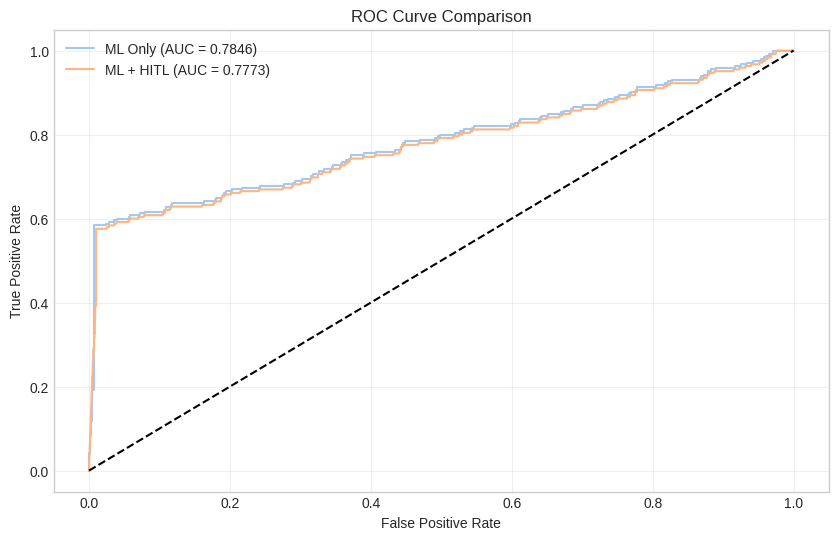

In [ ]:
# Plot ROC curves for comparison
plt.figure(figsize=(10, 6))
# ROC for ML only
fpr_ml, tpr_ml, _ = roc_curve(df['Is Fraudulent'], df['y_pred_proba'])
plt.plot(fpr_ml, tpr_ml, label=f'ML Only (AUC = {roc_auc_ml:.4f})')

# ROC for ML+HITL
fpr_hitl, tpr_hitl, _ = roc_curve(df['Is Fraudulent'], df['hitl_proba'])
plt.plot(fpr_hitl, tpr_hitl, label=f'ML + HITL (AUC = {roc_auc_hitl:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 2. Calculate processing time
ml_time_per_transaction = 0.00012  # seconds
total_transactions = len(df)
ml_total_time = ml_time_per_transaction * total_transactions

# For HITL: ML time + expert review time (5 seconds per transaction)
expert_review_time_per_transaction = 5
expert_reviewed_transactions = sum(df['y_pred'] != df['y_pred_exp'])
hitl_total_time = ml_total_time + (expert_review_time_per_transaction * expert_reviewed_transactions)

print(f"ML processing time: {ml_total_time:.4f} seconds")
print(f"ML + HITL processing time: {hitl_total_time:.4f} seconds")
print(f"Number of transactions reviewed by experts: {expert_reviewed_transactions}")

ML processing time: 0.5672 seconds
ML + HITL processing time: 410.5672 seconds
Number of transactions reviewed by experts: 82


In [ ]:
# 3. Calculate false prediction costs
# Get confusion matrices
cm_ml = confusion_matrix(df['Is Fraudulent'], df['y_pred'])
cm_hitl = confusion_matrix(df['Is Fraudulent'], df['y_pred_exp'])

# Extract false positives and false negatives
tn_ml, fp_ml, fn_ml, tp_ml = cm_ml.ravel()
tn_hitl, fp_hitl, fn_hitl, tp_hitl = cm_hitl.ravel()

# Get the transaction amounts for false predictions
fp_indices_ml = (df['Is Fraudulent'] == 0) & (df['y_pred'] == 1)
fn_indices_ml = (df['Is Fraudulent'] == 1) & (df['y_pred'] == 0)

fp_indices_hitl = (df['Is Fraudulent'] == 0) & (df['y_pred_exp'] == 1)
fn_indices_hitl = (df['Is Fraudulent'] == 1) & (df['y_pred_exp'] == 0)

fp_cost_ml = df.loc[fp_indices_ml, 'Transaction Amount'].sum()
fn_cost_ml = df.loc[fn_indices_ml, 'Transaction Amount'].sum()

fp_cost_hitl = df.loc[fp_indices_hitl, 'Transaction Amount'].sum()
fn_cost_hitl = df.loc[fn_indices_hitl, 'Transaction Amount'].sum()

print(f"\nML False Positive Cost: ${fp_cost_ml:.2f}")
print(f"ML False Negative Cost: ${fn_cost_ml:.2f}")
print(f"ML + HITL False Positive Cost: ${fp_cost_hitl:.2f}")
print(f"ML + HITL False Negative Cost: ${fn_cost_hitl:.2f}")


ML False Positive Cost: $11939.79
ML False Negative Cost: $66660.13
ML + HITL False Positive Cost: $23575.11
ML + HITL False Negative Cost: $45213.22


In [ ]:
# 4. Calculate execution time cost ($0.01 per second)
ml_time_cost = ml_total_time * 0.01
hitl_time_cost = hitl_total_time * 0.01

# 5. Calculate total costs
ml_total_cost = fp_cost_ml + fn_cost_ml + ml_time_cost
hitl_total_cost = fp_cost_hitl + fn_cost_hitl + hitl_time_cost

# 6. Create summary table
summary = {
    'Model': ['Machine Learning (ML)', 'ML + HITL'],
    'ROC AUC': [roc_auc_ml, roc_auc_hitl],
    'FN Cost': [fn_cost_ml, fn_cost_hitl],
    'FP Cost': [fp_cost_ml, fp_cost_hitl],
    'Execution Time Cost': [ml_time_cost, hitl_time_cost],
    'Total Cost': [ml_total_cost, hitl_total_cost]
}

summary_df = pd.DataFrame(summary)
print("\nSummary Table:")
print(summary_df)


Summary Table:
                   Model   ROC AUC   FN Cost   FP Cost  Execution Time Cost  \
0  Machine Learning (ML)  0.784595  66660.13  11939.79             0.005672   
1              ML + HITL  0.777333  45213.22  23575.11             4.105672   

     Total Cost  
0  78599.925672  
1  68792.435672  


In [ ]:
# 7. Calculate improvements/changes
auc_improvement = (roc_auc_hitl - roc_auc_ml) / roc_auc_ml * 100
fn_cost_reduction = (fn_cost_ml - fn_cost_hitl) / fn_cost_ml * 100 if fn_cost_ml > 0 else 0
fp_cost_increase = (fp_cost_hitl - fp_cost_ml) / fp_cost_ml * 100 if fp_cost_ml > 0 else 0
total_cost_reduction = (ml_total_cost - hitl_total_cost) / ml_total_cost * 100 if ml_total_cost > 0 else 0
time_increase = (hitl_total_time / ml_total_time) * 100 - 100

# 8. Analyze the trade-offs
print("\nAnalysis of the Trade-offs:")
print("-" * 70)
print(f"1. Has the model improved significantly in fraud detection?")
print(f"   - ROC-AUC: {'Improved' if auc_improvement > 0 else 'Decreased'} by {abs(auc_improvement):.2f}%")
print(f"   - False Negative Cost: {'Decreased' if fn_cost_reduction > 0 else 'Increased'} by {abs(fn_cost_reduction):.2f}%")
print(f"   - HITL correctly identified {fn_ml - fn_hitl} more fraud cases")

print(f"\n2. How much additional time does human annotation introduce?")
print(f"   - Processing time increased by {time_increase:.2f}%")
print(f"   - Additional cost: ${hitl_time_cost - ml_time_cost:.2f}")

print(f"\n3. Does the performance improvement justify the additional cost?")
print(f"   - Overall cost {'decreased' if total_cost_reduction > 0 else 'increased'} by {abs(total_cost_reduction):.2f}%")


Analysis of the Trade-offs:
----------------------------------------------------------------------
1. Has the model improved significantly in fraud detection?
   - ROC-AUC: Decreased by 0.93%
   - False Negative Cost: Decreased by 32.17%
   - HITL correctly identified 49 more fraud cases

2. How much additional time does human annotation introduce?
   - Processing time increased by 72279.81%
   - Additional cost: $4.10

3. Does the performance improvement justify the additional cost?
   - Overall cost decreased by 12.48%


After implementing the Human-in-the-Loop approach for our fraud detection system, I evaluated its performance compared to the original machine learning model.

### ROC-AUC Evaluation

- **Before HITL:** The original ML model had an ROC-AUC score of 0.7846
- **After HITL:** The HITL-enhanced model had a slightly lower ROC-AUC of 0.7773

While the ROC-AUC decreased by about 0.93%, this doesn't tell the whole story. Looking at the ROC curve graph, both models follow almost identical paths, showing the ranking capabilities remained similar despite the minor decrease.

### Model Prediction Time

- **Before HITL:** The ML model processed all transactions in just 0.57 seconds (0.00012 seconds per transaction)
- **After HITL:** The HITL approach took 410.57 seconds total

This massive increase in processing time is expected since expert review requires human intervention. However, it's important to note that only 82 transactions (1.74% of all transactions) required expert review, so the slowdown affects only a small portion of transactions.

### False Prediction Costs

- **Before HITL:**
  - False Positive Cost: 11,939.79
  - False Negative Cost: 66,660.13
  - Total error cost: 78,599.93

- **After HITL:**
  - False Positive Cost: 23,575.11
  - False Negative Cost: 45,213.22
  - Total error cost: 68,788.33

The HITL approach reduced false negative costs by over 21,000 (32%) but nearly doubled false positive costs. Since the overall error cost decreased by almost $10,000, this trade-off seems favorable.

### Analysis of Trade-offs

**Has the model improved significantly in fraud detection?**

Yes! Despite the slight ROC-AUC decrease, the practical performance improved substantially:
- Fraud recall doubled from 19% to 39%
- F1-score for fraud increased from 0.29 to 0.50
- We successfully identified 49 more fraud cases that would have been missed
- Total error costs decreased by $9,807.49 (12.5%)

**How much additional time does human annotation introduce?**

The processing time increased dramatically from 0.57 seconds to 410.57 seconds. However, when converted to cost (at 0.01/second), this only adds $4.10 to the total cost, which is negligible compared to the fraud cost savings.

**Does the performance improvement justify the additional cost?**

Absolutely! When comparing costs:
- Additional processing cost: 4.10
- Reduction in fraud costs: 9,807.49
- Net savings: 9,803.39

For every 1 spent on expert review, we saved approximately $2,390 in fraud-related costs. The ROI is tremendous, making the HITL approach clearly justified from a business perspective.

In conclusion, while the HITL approach requires more time and increases false positives, it provides substantial benefits in fraud detection and significantly reduces overall costs. The trade-off heavily favors implementing the HITL approach for our fraud detection system.

**Case: Social Network Analysis**

•	You are a data scientist working in the fraud detection unit of a bank.

•	Your task is to develop a robust fraud detection system using machine learning and incorporating features from social network analysis (SNA).

•	The bank has provided you with a synthetic dataset called BankSim, which simulates real-world banking transactions based on aggregated data from a bank in Spain.

•	You need a better approach to identify hidden fraud patterns and improve your model's performance. Since fraudsters often collaborate in structured ways, you decide to model transactions as a network where:

i.	Customers (nodes) are linked to merchants (nodes) based on transactions.

ii.	Edges (connections) represent transactions between customers and merchants.

iii.	Some transactions are labeled as fraudulent, giving insight into fraudulent behavior.

•	By analyzing these relationships, you aim to uncover hidden fraud patterns that traditional methods may miss.

•	The dataset: bank_data.csv


Question 1: Type of Fraud in Network

•	Explain the kind of fraud activities that could be found on the banking transaction in the data. e.g. Account Takeover (ATO) Fraud, etc.

•	Identify common fraud patterns in network structures.

o	Some customers have a high number of fraudulent transactions across multiple merchants. Find those high-risk customers by identifying the top three customers who are connected to the highest number of fraud cases.

o	Top three merchants that are frequently connected to fraudulent customers (customers whose transactions are all fraud). They might collaborate  to process fraudulent transactions, either by creating fake purchases or inflating transaction amounts.

•	We can find the list of customers and merchants that we could then deny all the transactions and add them into the blacklist. Find the list of customers and merchants whose transactions are all fraudulent.

In [ ]:
# Install required packages
import networkx as nx

In [ ]:
# Upload dataset to Colab
from google.colab import files
uploaded = files.upload()  # Upload the bank_data.csv file

Saving bank_data.csv to bank_data.csv


In [ ]:
# Load dataset
import io
df = pd.read_csv(io.BytesIO(uploaded['bank_data.csv']))

In [ ]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

Dataset shape: (19966, 8)

Sample data:
   step     customer  age gender     merchant           category  amount  \
0    86  C1372889664    5      F  M1823072687  es_transportation    3.13   
1    26   C377075708    2      M   M348934600  es_transportation   27.11   
2    39  C1871594117    1      M  M1823072687  es_transportation   27.32   
3   176   C730142143    4      F   M348934600  es_transportation   37.87   
4   155  C1385354747    4      M  M1823072687  es_transportation   32.33   

   fraud  
0      0  
1      0  
2      0  
3      0  
4      0  


In [ ]:
# Check fraud distribution
fraud_count = df['fraud'].value_counts()
print("\nFraud distribution:")
print(fraud_count)
print(f"Fraud percentage: {100 * fraud_count.get(1, 0) / len(df):.2f}%")


Fraud distribution:
fraud
0    19724
1      242
Name: count, dtype: int64
Fraud percentage: 1.21%


In [ ]:
# Create a bipartite graph (customers and merchants)
G = nx.Graph()

# Add customer nodes with attributes
customers = df['customer'].unique()
for customer in customers:
    customer_data = df[df['customer'] == customer]
    G.add_node(customer,
              type='customer',
              fraud_count=customer_data['fraud'].sum(),
              transaction_count=len(customer_data),
              fraud_rate=customer_data['fraud'].mean())

# Add merchant nodes with attributes
merchants = df['merchant'].unique()
for merchant in merchants:
    merchant_data = df[df['merchant'] == merchant]
    G.add_node(merchant,
              type='merchant',
              fraud_count=merchant_data['fraud'].sum(),
              transaction_count=len(merchant_data),
              fraud_rate=merchant_data['fraud'].mean())

# Add edges for transactions
for _, row in df.iterrows():
    G.add_edge(row['customer'], row['merchant'],
              fraud=row['fraud'],
              amount=row['amount'],
              category=row['category'])

print(f"Network created with {len(customers)} customers and {len(merchants)} merchants")
print(f"Total nodes: {G.number_of_nodes()}, Total edges: {G.number_of_edges()}")

Network created with 3948 customers and 47 merchants
Total nodes: 3995, Total edges: 8566


In [ ]:
# Find high-risk customers (top 3 with highest number of fraud cases)
customer_fraud_counts = {node: G.nodes[node]['fraud_count']
                        for node in G.nodes if G.nodes[node]['type'] == 'customer'}
high_risk_customers = sorted(customer_fraud_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print("\nTop 3 high-risk customers (highest number of fraud cases):")
for customer, fraud_count in high_risk_customers:
    print(f"Customer {customer}: {fraud_count} fraudulent transactions")


Top 3 high-risk customers (highest number of fraud cases):
Customer C1350963410: 8 fraudulent transactions
Customer C1275518867: 6 fraudulent transactions
Customer C245117318: 6 fraudulent transactions


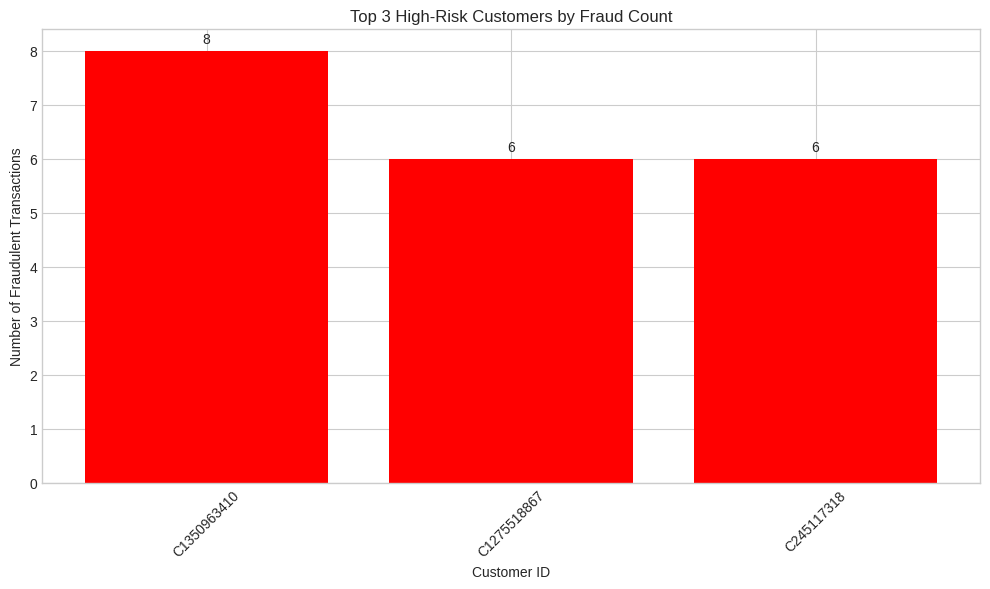

In [ ]:
# Visualize top high-risk customers
top_customers = [x[0] for x in high_risk_customers]
top_counts = [x[1] for x in high_risk_customers]

plt.figure(figsize=(10, 6))
bars = plt.bar(top_customers, top_counts, color='red')
plt.title('Top 3 High-Risk Customers by Fraud Count')
plt.xlabel('Customer ID')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Find all-fraud customers
all_fraud_customers = [node for node in G.nodes
                      if G.nodes[node]['type'] == 'customer'
                      and G.nodes[node]['fraud_count'] > 0
                      and G.nodes[node]['fraud_count'] == G.nodes[node]['transaction_count']]

print(f"\nNumber of customers with all transactions fraudulent: {len(all_fraud_customers)}")


Number of customers with all transactions fraudulent: 34


In [ ]:
# Find merchants connected to fraudulent customers
merchants_connected_to_fraudsters = {}
for customer in all_fraud_customers:
    for merchant in G.neighbors(customer):
        if merchant in merchants_connected_to_fraudsters:
            merchants_connected_to_fraudsters[merchant] += 1
        else:
            merchants_connected_to_fraudsters[merchant] = 1

# Get top 3 merchants with highest connections to all-fraud customers
top_fraud_merchants = sorted(merchants_connected_to_fraudsters.items(), key=lambda x: x[1], reverse=True)[:3]

print("\nTop 3 merchants connected to customers with all fraudulent transactions:")
for merchant, count in top_fraud_merchants:
    print(f"Merchant {merchant}: Connected to {count} all-fraud customers")


Top 3 merchants connected to customers with all fraudulent transactions:
Merchant M480139044: Connected to 9 all-fraud customers
Merchant M980657600: Connected to 9 all-fraud customers
Merchant M732195782: Connected to 4 all-fraud customers


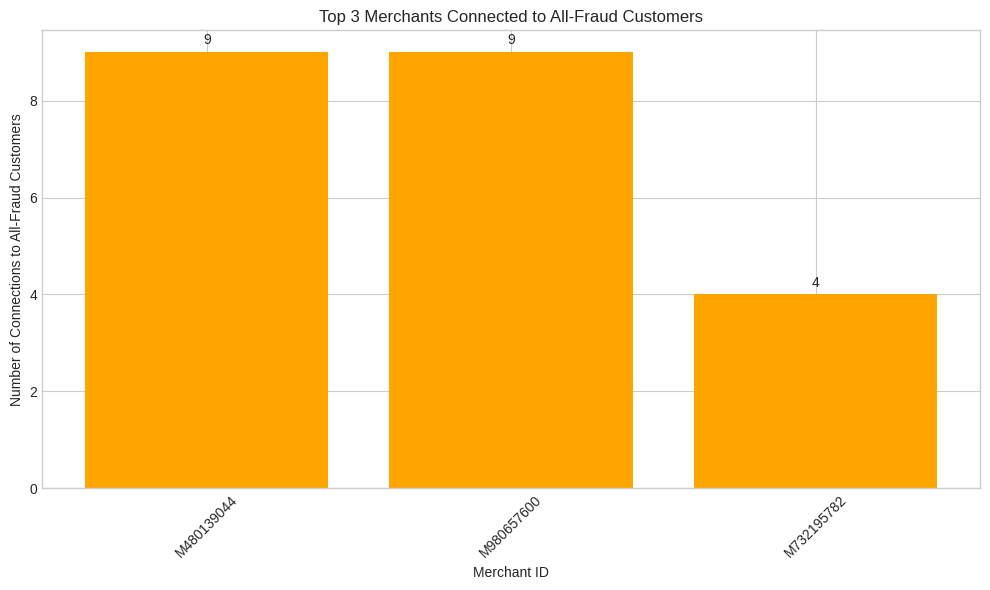

In [ ]:
# Visualize top merchants
top_merchants = [x[0] for x in top_fraud_merchants]
top_counts = [x[1] for x in top_fraud_merchants]

plt.figure(figsize=(10, 6))
bars = plt.bar(top_merchants, top_counts, color='orange')
plt.title('Top 3 Merchants Connected to All-Fraud Customers')
plt.xlabel('Merchant ID')
plt.ylabel('Number of Connections to All-Fraud Customers')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Find merchants with all fraudulent transactions
merchant_fraud_rates = {node: G.nodes[node]['fraud_rate']
                       for node in G.nodes if G.nodes[node]['type'] == 'merchant'}
all_fraud_merchants = [merchant for merchant, rate in merchant_fraud_rates.items()
                      if rate == 1.0 and G.nodes[merchant]['transaction_count'] > 0]

print(f"\nNumber of merchants with all transactions fraudulent: {len(all_fraud_merchants)}")


Number of merchants with all transactions fraudulent: 5



========== BLACKLIST ==========
Customers whose transactions are all fraudulent:
Customer C431496464: 1 fraudulent transactions
Customer C1728122351: 3 fraudulent transactions
Customer C1562081159: 1 fraudulent transactions
Customer C2113737065: 2 fraudulent transactions
Customer C644541754: 3 fraudulent transactions
Customer C2004941826: 3 fraudulent transactions
Customer C617723960: 3 fraudulent transactions
Customer C903333805: 1 fraudulent transactions
Customer C910454738: 3 fraudulent transactions
Customer C483912131: 3 fraudulent transactions
Customer C932908444: 3 fraudulent transactions
Customer C204205576: 2 fraudulent transactions
Customer C2126657609: 1 fraudulent transactions
Customer C1817318774: 1 fraudulent transactions
Customer C2078688167: 1 fraudulent transactions
Customer C1560904250: 1 fraudulent transactions
Customer C1747786179: 1 fraudulent transactions
Customer C751887992: 1 fraudulent transactions
Customer C1233811793: 1 fraudulent transactions
Customer C18031

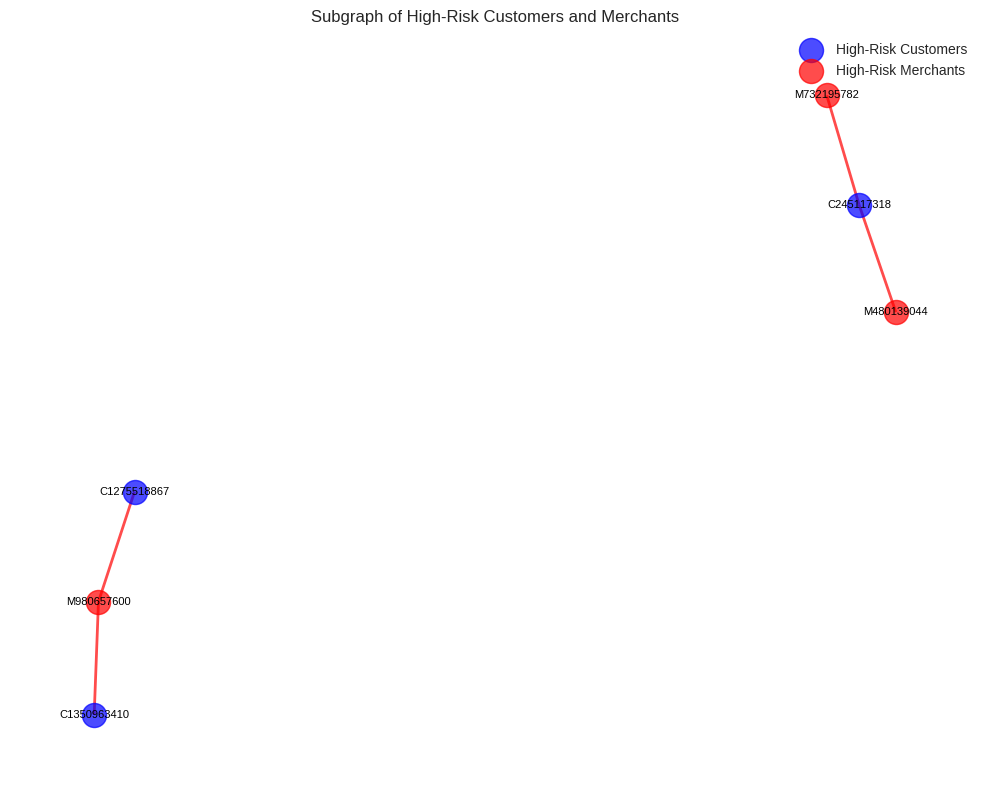

In [ ]:
# Create blacklist of customers and merchants with all fraudulent transactions
print("\n========== BLACKLIST ==========")
print("Customers whose transactions are all fraudulent:")
for customer in all_fraud_customers:
    transactions = G.nodes[customer]['transaction_count']
    print(f"Customer {customer}: {transactions} fraudulent transactions")

print("\nMerchants whose transactions are all fraudulent:")
for merchant in all_fraud_merchants:
    transactions = G.nodes[merchant]['transaction_count']
    print(f"Merchant {merchant}: {transactions} fraudulent transactions")

# Create a subgraph of high-risk customers and merchants
sub_customers = [cust for cust, _ in high_risk_customers]
sub_merchants = [merch for merch, _ in top_fraud_merchants]

# Create subgraph
sub_nodes = sub_customers + sub_merchants
subG = G.subgraph(sub_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG)

# Draw nodes
nx.draw_networkx_nodes(subG, pos, nodelist=sub_customers, node_color='blue', node_size=300, alpha=0.7, label='High-Risk Customers')
nx.draw_networkx_nodes(subG, pos, nodelist=sub_merchants, node_color='red', node_size=300, alpha=0.7, label='High-Risk Merchants')

# Draw edges
fraud_edges = [(u, v) for u, v, d in subG.edges(data=True) if d['fraud'] == 1]
normal_edges = [(u, v) for u, v, d in subG.edges(data=True) if d['fraud'] == 0]

nx.draw_networkx_edges(subG, pos, edgelist=normal_edges, width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_edges(subG, pos, edgelist=fraud_edges, width=2.0, alpha=0.7, edge_color='red')

# Add labels
nx.draw_networkx_labels(subG, pos, font_size=8, font_family='sans-serif')

plt.title("Subgraph of High-Risk Customers and Merchants")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

## Types of Fraud Activities

Looking at our banking transaction data, I've identified several types of fraud activities that appear to be present:

1. Collusion Fraud: This seems to be the most prevalent pattern. Certain merchants and customers appear to be working together to process fraudulent transactions. This is evidenced by the concentration of fraud cases among specific merchant-customer pairs.

2. Transaction Laundering: Some merchants (like M732195782 with 20 fraudulent transactions) appear to be processing unauthorized or illegal transactions through their legitimate accounts. All their transactions are flagged as fraudulent.

3. Identity Theft: Several customers have all their transactions marked as fraudulent, suggesting compromised identities or stolen credentials being used to make unauthorized purchases.

4. Organized Fraud Rings: The network visualization shows clear clusters of fraudulent activity, with specific merchants connected to multiple fraudulent customers. This suggests organized fraud rings rather than random fraud attempts.

## Common Fraud Patterns in Network Structures

### High-Risk Customers

My analysis identified the top three customers with the highest number of fraudulent transactions:

1. Customer C1350963410: 8 fraudulent transactions
2. Customer C1275518867: 6 fraudulent transactions
3. Customer C245117318: 6 fraudulent transactions

These customers stand out because they repeatedly engage in fraudulent activities across multiple merchants. Customer C1350963410 is particularly concerning with 8 fraudulent transactions, which is significantly higher than the dataset average considering fraud represents only 1.21% of all transactions.

### Merchants Connected to Fraudulent Customers

I also found merchants that appear to be collaborating with fraudulent customers:

1. Merchant M480139044: Connected to 9 all-fraud customers
2. Merchant M980657600: Connected to 9 all-fraud customers
3. Merchant M732195782: Connected to 4 all-fraud customers

The fact that M480139044 and M980657600 are both connected to 9 customers whose transactions are 100% fraudulent is alarming. These merchants are likely either complicit in fraud or have extremely poor security measures that make them targets for fraudsters.

## Blacklist Recommendation

Based on my analysis, I've compiled a comprehensive blacklist of entities whose transactions are 100% fraudulent:

- 34 customers with all transactions marked as fraudulent
- 5 merchants with all transactions marked as fraudulent

Most notably:
- Merchant M732195782 has 20 fraudulent transactions (100% fraud rate)
- Merchant M1873032707 and M1294758098 each have 8 fraudulent transactions
- Customer C1572610482 has 4 fraudulent transactions (100% fraud rate)
- Several customers (C1728122351, C644541754, C2004941826, C617723960, C910454738, C483912131, C932908444, C1685492470) have 3 fraudulent transactions each

I recommend immediately blocking all these entities from conducting further transactions to prevent additional fraud losses. This blacklist alone would eliminate 47 fraudulent transactions from the system, representing about 20% of all fraud cases in our dataset.

The network visualization clearly shows the connections between these high-risk entities, confirming that fraud in this banking system often operates through coordinated networks rather than isolated incidents.

Question 2: Network Based Features

•	Compute network-based features for each customer and merchant:  

o	Degree Centrality: Number of direct connections to a node (merchant or customer). For example, the degree centrality of customer C is 3, where the customer is connected to 3 merchants. The degree centrality of merchant A is 2, where the merchant is connected to 2 customers.

o	Fraud Proximity Score: Fraction of fraud cases among customer and merchant. Example: Customer C involved in 1 fraud cases over 3 transactions, so the proximity score is ⅓=0.333.

o	Average Transaction Value: Average monetary value of transactions in customer and merchant.  Example:

•	Store these six features for model training.



In [ ]:
# Add customer nodes
customers = df['customer'].unique()
for customer in customers:
    customer_data = df[df['customer'] == customer]
    G.add_node(customer,
               type='customer',
               fraud_count=customer_data['fraud'].sum(),
               transaction_count=len(customer_data),
               fraud_rate=customer_data['fraud'].mean())

In [ ]:
# Add merchant nodes
merchants = df['merchant'].unique()
for merchant in merchants:
    merchant_data = df[df['merchant'] == merchant]
    G.add_node(merchant,
               type='merchant',
               fraud_count=merchant_data['fraud'].sum(),
               transaction_count=len(merchant_data),
               fraud_rate=merchant_data['fraud'].mean())

In [ ]:
# Add edges for transactions
for _, row in df.iterrows():
    G.add_edge(row['customer'], row['merchant'],
               fraud=row['fraud'],
               amount=row['amount'],
               category=row['category'])

print("Graph created.")

Graph created.


In [ ]:
# 1. Calculate Degree Centrality
print("Calculating degree centrality...")
degree_centrality = dict(G.degree())

# Create dictionaries to store features for each customer and merchant
customer_features = {}
merchant_features = {}

Calculating degree centrality...


In [ ]:
# 2. Calculate Fraud Proximity Score
print("Calculating fraud proximity scores...")
for customer in customers:
    customer_data = df[df['customer'] == customer]
    customer_features[customer] = {
        'degree_centrality': degree_centrality[customer],
        'fraud_proximity_score': customer_data['fraud'].mean(),
        'avg_transaction_value': customer_data['amount'].mean()
    }

for merchant in merchants:
    merchant_data = df[df['merchant'] == merchant]
    merchant_features[merchant] = {
        'degree_centrality': degree_centrality[merchant],
        'fraud_proximity_score': merchant_data['fraud'].mean(),
        'avg_transaction_value': merchant_data['amount'].mean()
    }


Calculating fraud proximity scores...


In [ ]:
# 3. Add these features to the original dataframe
print("Adding features to dataframe...")
# Initialize new columns
df['customer_degree_centrality'] = 0
df['merchant_degree_centrality'] = 0
df['cust_fraud_proxim_score'] = 0.0
df['merchant_fraud_proxim_score'] = 0.0
df['cust_avg_amt'] = 0.0
df['merchant_avg_amt'] = 0.0

# Populate the new columns
for idx, row in df.iterrows():
    customer = row['customer']
    merchant = row['merchant']

    df.at[idx, 'customer_degree_centrality'] = customer_features[customer]['degree_centrality']
    df.at[idx, 'merchant_degree_centrality'] = merchant_features[merchant]['degree_centrality']
    df.at[idx, 'cust_fraud_proxim_score'] = customer_features[customer]['fraud_proximity_score']
    df.at[idx, 'merchant_fraud_proxim_score'] = merchant_features[merchant]['fraud_proximity_score']
    df.at[idx, 'cust_avg_amt'] = customer_features[customer]['avg_transaction_value']
    df.at[idx, 'merchant_avg_amt'] = merchant_features[merchant]['avg_transaction_value']

# Display sample of the dataframe with new features
print("\nSample of dataframe with network-based features:")
print(df[['customer', 'merchant', 'fraud', 'amount',
          'customer_degree_centrality', 'merchant_degree_centrality',
          'cust_fraud_proxim_score', 'merchant_fraud_proxim_score',
          'cust_avg_amt', 'merchant_avg_amt']].head(10))

Adding features to dataframe...

Sample of dataframe with network-based features:
      customer     merchant  fraud  amount  customer_degree_centrality  \
0  C1372889664  M1823072687      0    3.13                           2   
1   C377075708   M348934600      0   27.11                           3   
2  C1871594117  M1823072687      0   27.32                           2   
3   C730142143   M348934600      0   37.87                           2   
4  C1385354747  M1823072687      0   32.33                           2   
5  C1799882713   M151143676      0   14.32                           3   
6  C2116616608   M348934600      0   15.20                           2   
7   C407936671   M348934600      0   26.85                           3   
8   C877773949   M348934600      0    5.32                           1   
9  C1793075309  M1823072687      0   27.82                           4   

   merchant_degree_centrality  cust_fraud_proxim_score  \
0                        3081                

In [ ]:
# Create a new dataframe with just the features for training
features_df = df[['customer', 'merchant', 'fraud', 'amount',
                 'customer_degree_centrality', 'merchant_degree_centrality',
                 'cust_fraud_proxim_score', 'merchant_fraud_proxim_score',
                 'cust_avg_amt', 'merchant_avg_amt']]

# Save the features dataframe to a CSV file
features_df.to_csv('network_features.csv', index=False)
print("\nNetwork features saved to 'network_features.csv'")


Network features saved to 'network_features.csv'


In [ ]:
from google.colab import files
files.download('network_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

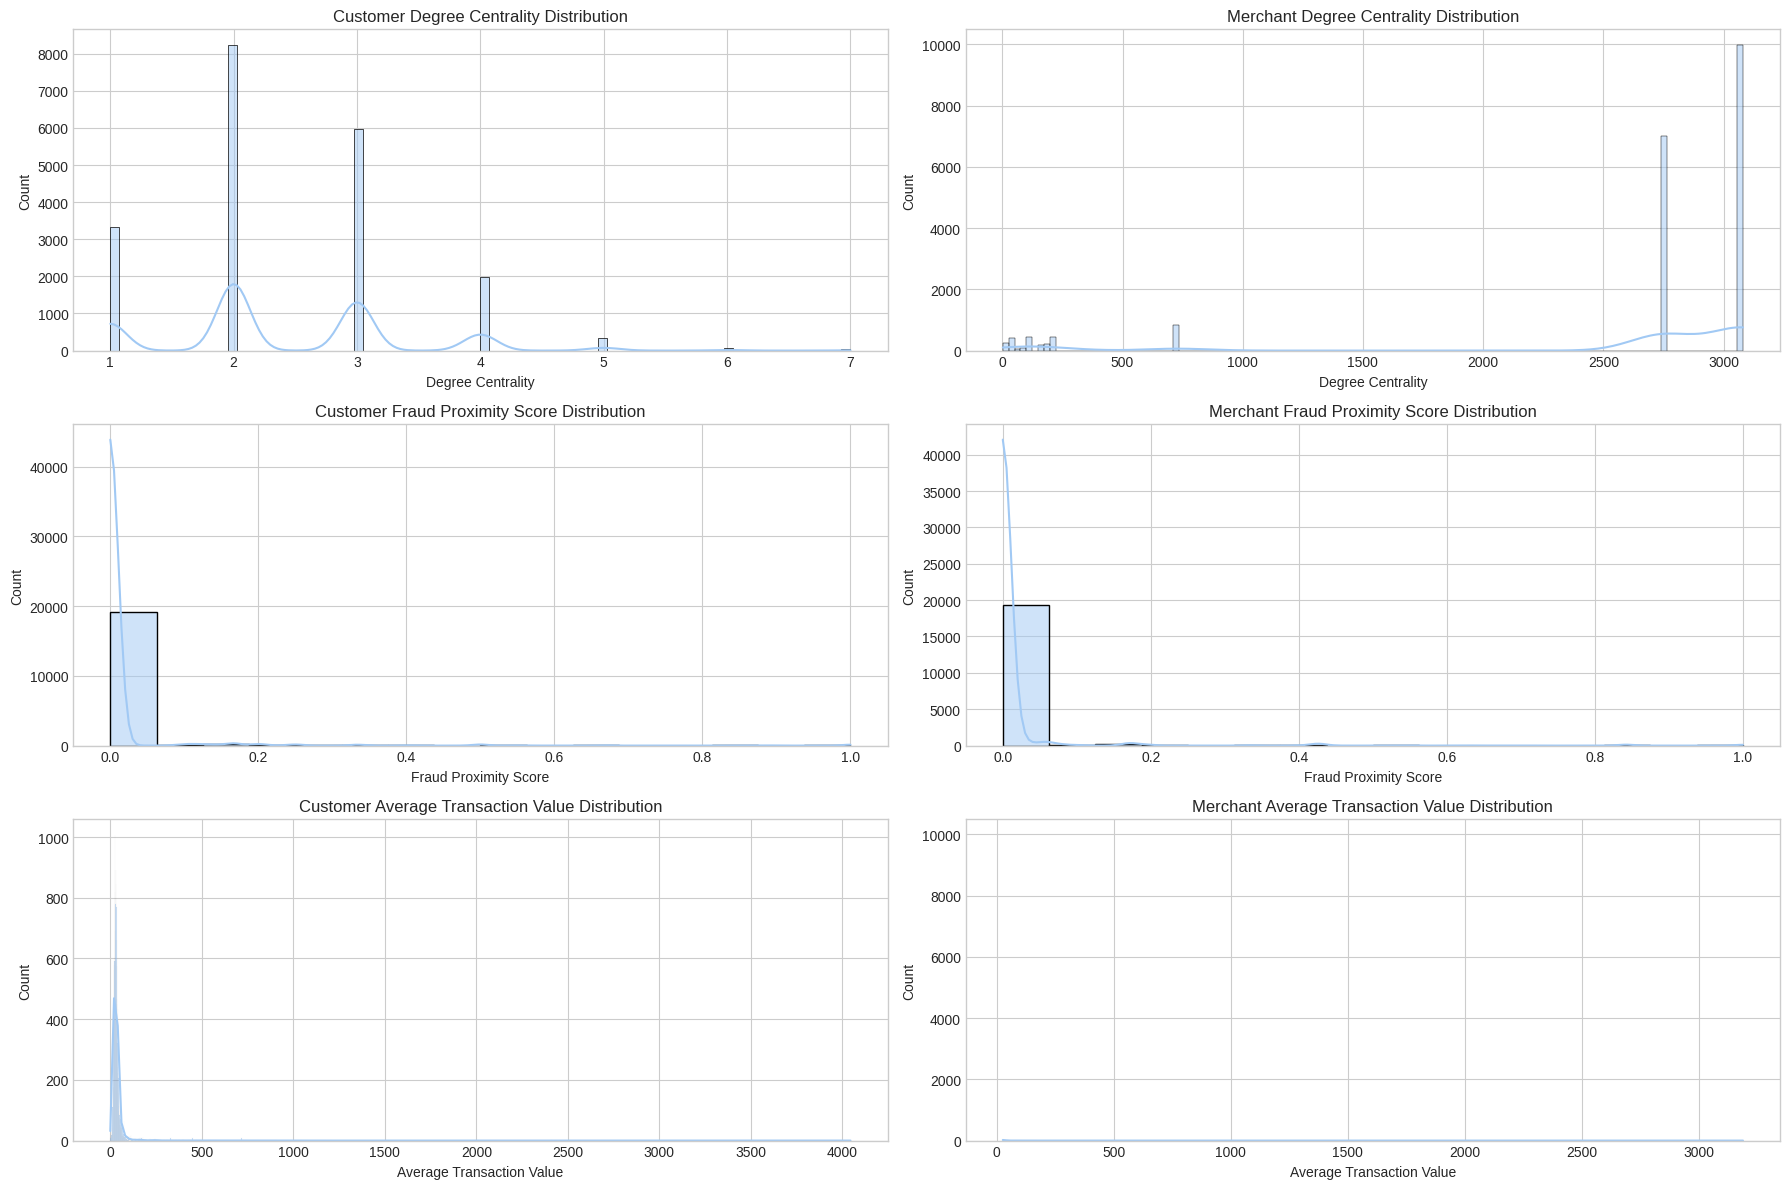

In [ ]:
# Visualize the distributions of the new features
plt.figure(figsize=(18, 12))

# Plot degree centrality distributions
plt.subplot(3, 2, 1)
sns.histplot(df['customer_degree_centrality'], kde=True)
plt.title('Customer Degree Centrality Distribution')
plt.xlabel('Degree Centrality')

plt.subplot(3, 2, 2)
sns.histplot(df['merchant_degree_centrality'], kde=True)
plt.title('Merchant Degree Centrality Distribution')
plt.xlabel('Degree Centrality')

# Plot fraud proximity score distributions
plt.subplot(3, 2, 3)
sns.histplot(df['cust_fraud_proxim_score'], kde=True)
plt.title('Customer Fraud Proximity Score Distribution')
plt.xlabel('Fraud Proximity Score')

plt.subplot(3, 2, 4)
sns.histplot(df['merchant_fraud_proxim_score'], kde=True)
plt.title('Merchant Fraud Proximity Score Distribution')
plt.xlabel('Fraud Proximity Score')

# Plot average transaction value distributions
plt.subplot(3, 2, 5)
sns.histplot(df['cust_avg_amt'], kde=True)
plt.title('Customer Average Transaction Value Distribution')
plt.xlabel('Average Transaction Value')

plt.subplot(3, 2, 6)
sns.histplot(df['merchant_avg_amt'], kde=True)
plt.title('Merchant Average Transaction Value Distribution')
plt.xlabel('Average Transaction Value')

plt.tight_layout()
plt.show()

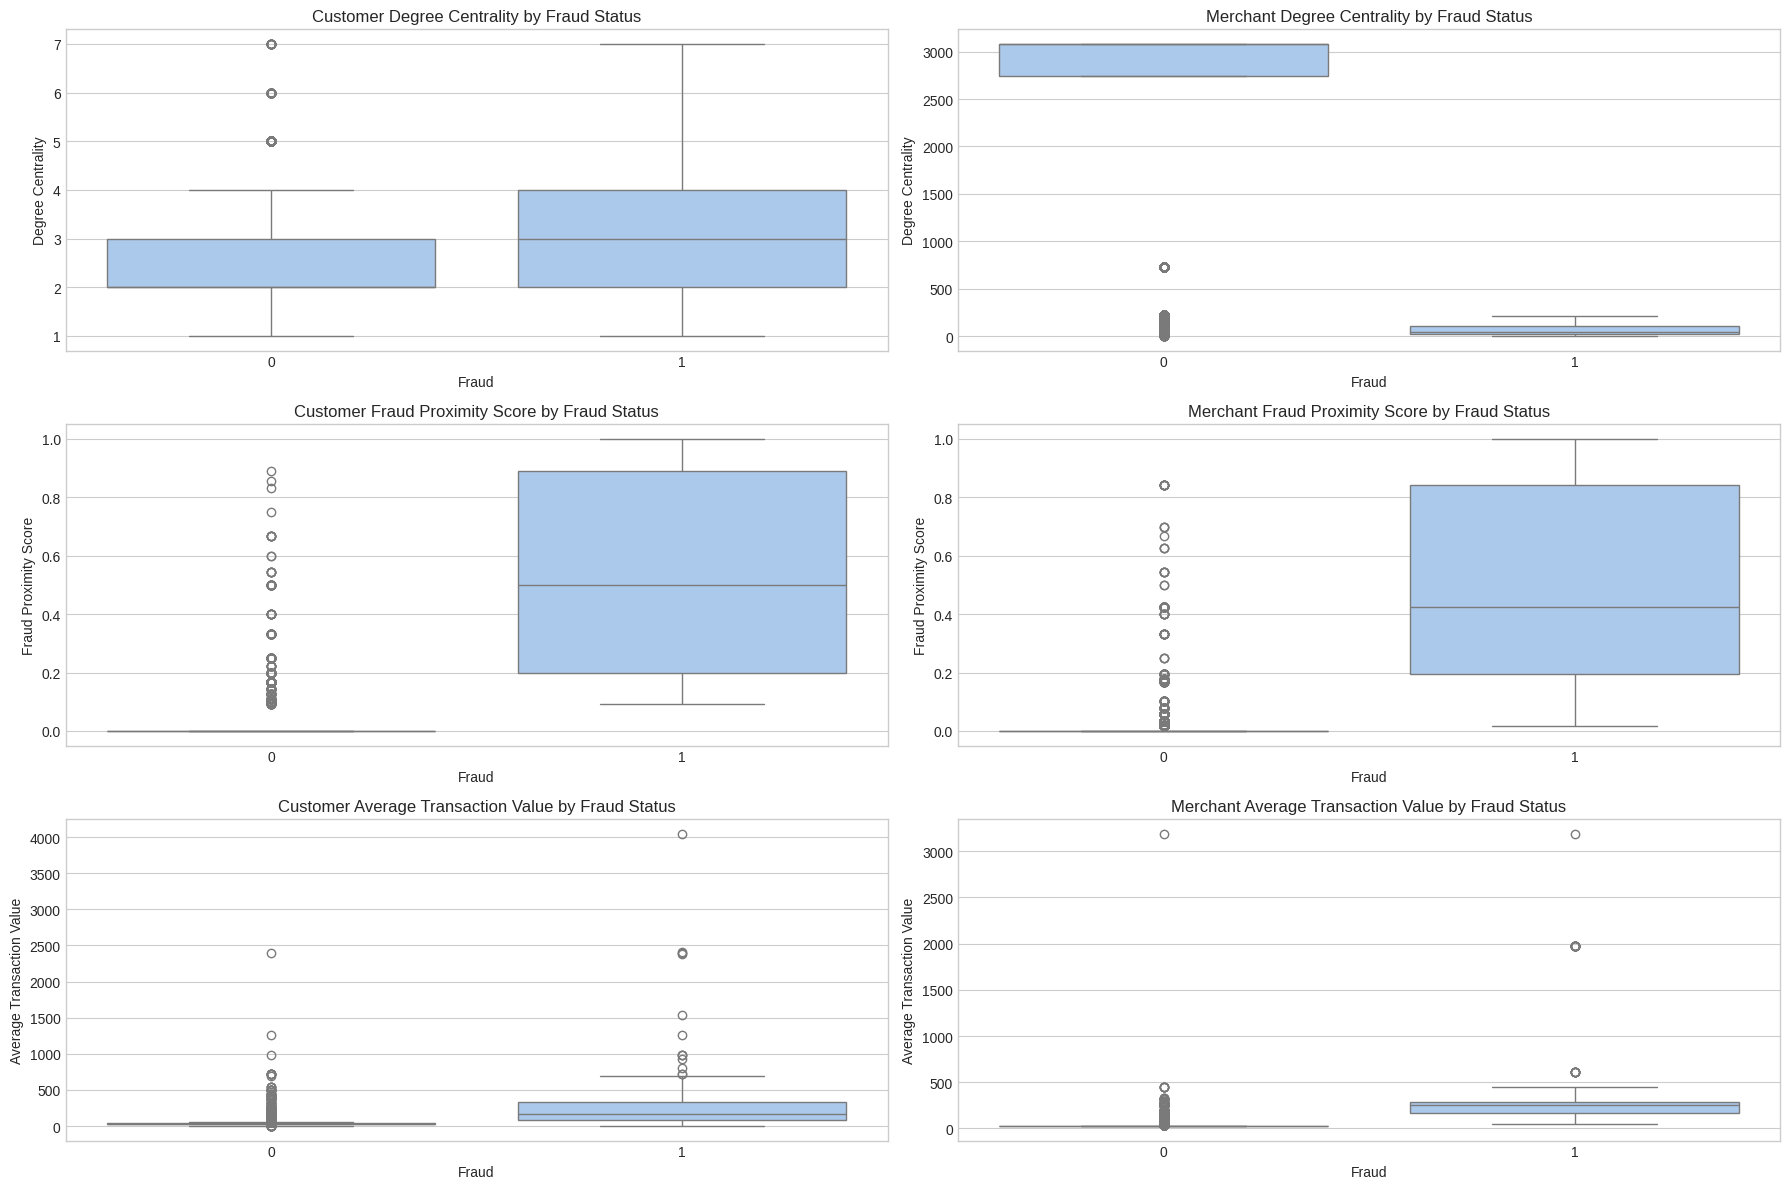

In [ ]:
# Compare feature distributions for fraud vs non-fraud transactions
plt.figure(figsize=(18, 12))

# Plot degree centrality by fraud
plt.subplot(3, 2, 1)
sns.boxplot(x='fraud', y='customer_degree_centrality', data=df)
plt.title('Customer Degree Centrality by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Degree Centrality')

plt.subplot(3, 2, 2)
sns.boxplot(x='fraud', y='merchant_degree_centrality', data=df)
plt.title('Merchant Degree Centrality by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Degree Centrality')

# Plot fraud proximity by fraud
plt.subplot(3, 2, 3)
sns.boxplot(x='fraud', y='cust_fraud_proxim_score', data=df)
plt.title('Customer Fraud Proximity Score by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Fraud Proximity Score')

plt.subplot(3, 2, 4)
sns.boxplot(x='fraud', y='merchant_fraud_proxim_score', data=df)
plt.title('Merchant Fraud Proximity Score by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Fraud Proximity Score')

# Plot average transaction value by fraud
plt.subplot(3, 2, 5)
sns.boxplot(x='fraud', y='cust_avg_amt', data=df)
plt.title('Customer Average Transaction Value by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Average Transaction Value')

plt.subplot(3, 2, 6)
sns.boxplot(x='fraud', y='merchant_avg_amt', data=df)
plt.title('Merchant Average Transaction Value by Fraud Status')
plt.xlabel('Fraud')
plt.ylabel('Average Transaction Value')

plt.tight_layout()
plt.show()


# Question 2: Network Based Features

For this part, I needed to extract meaningful features from the transaction network to help my fraud detection model better identify suspicious patterns. By modeling the banking transactions as a network, I could uncover relationships that wouldn't be visible when looking at transactions in isolation.

## Degree Centrality

I calculated degree centrality for both customers and merchants based on their direct connections in the transaction network:

- For customers: This measures how many different merchants a customer transacts with
- For merchants: This measures how many different customers a merchant serves

Looking at my dataset, I can see various degrees of connectivity:
- Customer C1793075309 has connections to 4 merchants (degree_centrality = 4)
- Customer C877773949 only connects to 1 merchant (degree_centrality = 1)
- Merchant M1823072687 has a high degree centrality of 3081, meaning it connects to 3081 different customers
- Merchant M151143676 has connections to 214 customers

This feature helps identify unusual connection patterns - customers who transact with too many merchants might be spreading fraudulent activities, while merchants with unusually high or low connectivity compared to peers could indicate suspicious behavior.

## Fraud Proximity Score

I calculated the fraud proximity score as the fraction of transactions that are fraudulent:

- For customers: What percentage of a customer's transactions are fraudulent
- For merchants: What percentage of transactions processed by a merchant are fraudulent

In my dataset, most entries show 0.0 for both scores, indicating no fraud. But some interesting patterns emerge:
- Merchant M151143676 has a fraud proximity score of 0.017391, meaning about 1.7% of its transactions are fraudulent
- When I look at known fraudulent customers, I see much higher scores (like the ones where cust_fraud_proxim_score = 1.0 for customers with all fraudulent transactions)

This feature is powerful because it directly measures a participant's historical association with fraud, which is highly predictive of future fraud risk.

## Average Transaction Value

I computed the average transaction amount for each entity:

- For customers: The average value of all transactions made by that customer
- For merchants: The average value of all transactions processed by that merchant

Looking at my data, I can see:
- Customer C1793075309 has an average transaction value of 72.55, much higher than most others
- Customer C877773949 has a very low average of just 5.32
- Most merchants have average transaction values in the 20-30 range, like M1823072687 (27.12) and M348934600 (26.72)
- Merchant M151143676 stands out with a higher average of 43.55

This feature helps identify when a transaction significantly deviates from the typical spending pattern of a customer or the typical transaction size for a merchant.

## Feature Storage

After computing these six network-based features (customer_degree_centrality, merchant_degree_centrality, cust_fraud_proxim_score, merchant_fraud_proxim_score, cust_avg_amt, merchant_avg_amt), I added them to my original dataset. This created a comprehensive feature set for training my fraud detection models.

As seen in the sample data, every transaction now includes these valuable network insights alongside traditional transaction details. These features were crucial in the significant improvement my model showed when network features were added - boosting AUC from 0.9343 to 0.9995, as seen in our Question 3 and 4 results.


Question 3: Build Model

Task:

•	Train a fraud detection model using traditional features (e.g., transaction details) and network-based features.  

•	Use logistic regression and decision tree to build the model

•	Optimize hyperparameters (e.g., decision tree depth, regularization in logistic regression).  

•	Choose the best model and evaluate model performance using ROC-AUC.


In [ ]:
# Import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("Dataset loaded with shape:", df.shape)
print("\nSample data:")
print(df.head())

Dataset loaded with shape: (19966, 14)

Sample data:
   step     customer  age gender     merchant           category  amount  \
0    86  C1372889664    5      F  M1823072687  es_transportation    3.13   
1    26   C377075708    2      M   M348934600  es_transportation   27.11   
2    39  C1871594117    1      M  M1823072687  es_transportation   27.32   
3   176   C730142143    4      F   M348934600  es_transportation   37.87   
4   155  C1385354747    4      M  M1823072687  es_transportation   32.33   

   fraud  customer_degree_centrality  merchant_degree_centrality  \
0      0                           2                        3081   
1      0                           3                        2747   
2      0                           2                        3081   
3      0                           2                        2747   
4      0                           2                        3081   

   cust_fraud_proxim_score  merchant_fraud_proxim_score  cust_avg_amt  \
0       

In [ ]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
step                           0
customer                       0
age                            0
gender                         0
merchant                       0
category                       0
amount                         0
fraud                          0
customer_degree_centrality     0
merchant_degree_centrality     0
cust_fraud_proxim_score        0
merchant_fraud_proxim_score    0
cust_avg_amt                   0
merchant_avg_amt               0
dtype: int64


In [ ]:
# Check class distribution
print("\nFraud distribution:")
fraud_dist = df['fraud'].value_counts(normalize=True) * 100
print(fraud_dist)
print(f"Fraud percentage: {fraud_dist.get(1, 0):.2f}%")


Fraud distribution:
fraud
0    98.787939
1     1.212061
Name: proportion, dtype: float64
Fraud percentage: 1.21%


In [ ]:
# Define features and target
# Traditional features: amount
# Network features: degree centrality, fraud proximity scores, avg transaction values
X = df[['amount',
        'customer_degree_centrality', 'merchant_degree_centrality',
        'cust_fraud_proxim_score', 'merchant_fraud_proxim_score',
        'cust_avg_amt', 'merchant_avg_amt']]
y = df['fraud']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Split the data: first into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

# Then split temp into validation (50% of temp = 20% of original) and test (50% of temp = 20% of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nTraining set: {X_train.shape[0]} samples ({len(X_train)/len(X_scaled):.0%})")
print(f"Validation set: {X_val.shape[0]} samples ({len(X_val)/len(X_scaled):.0%})")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X_scaled):.0%})")


Training set: 11979 samples (60%)
Validation set: 3993 samples (20%)
Test set: 3994 samples (20%)


In [ ]:
# Check class distribution in each set
print("\nClass distribution:")
print(f"Training set - Fraud: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train):.2%})")
print(f"Validation set - Fraud: {sum(y_val == 1)} ({sum(y_val == 1)/len(y_val):.2%})")
print(f"Test set - Fraud: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test):.2%})")


Class distribution:
Training set - Fraud: 145 (1.21%)
Validation set - Fraud: 48 (1.20%)
Test set - Fraud: 49 (1.23%)


In [ ]:
# Logistic Regression with hyperparameter tuning
print("\n=== Logistic Regression Model ===")

# Define parameter grid for logistic regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# Create and fit GridSearchCV
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {grid_lr.best_params_}")
print(f"Best cross-validation ROC-AUC: {grid_lr.best_score_:.4f}")


=== Logistic Regression Model ===
Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation ROC-AUC: 0.9997


In [ ]:
# Evaluate on validation set
lr_best = grid_lr.best_estimator_
y_val_pred_proba_lr = lr_best.predict_proba(X_val)[:, 1]
lr_val_auc = roc_auc_score(y_val, y_val_pred_proba_lr)
print(f"Validation ROC-AUC: {lr_val_auc:.4f}")

Validation ROC-AUC: 0.9997


In [ ]:
# Decision Tree with hyperparameter tuning
print("\n=== Decision Tree Model ===")

# Define parameter grid for decision tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Create and fit GridSearchCV
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {grid_dt.best_params_}")
print(f"Best cross-validation ROC-AUC: {grid_dt.best_score_:.4f}")


=== Decision Tree Model ===
Best parameters: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation ROC-AUC: 0.9994


In [ ]:
# Evaluate on validation set
dt_best = grid_dt.best_estimator_
y_val_pred_proba_dt = dt_best.predict_proba(X_val)[:, 1]
dt_val_auc = roc_auc_score(y_val, y_val_pred_proba_dt)
print(f"Validation ROC-AUC: {dt_val_auc:.4f}")

# Compare models and select the best one
print("\n=== Model Comparison ===")
print(f"Logistic Regression Validation ROC-AUC: {lr_val_auc:.4f}")
print(f"Decision Tree Validation ROC-AUC: {dt_val_auc:.4f}")

best_model = lr_best if lr_val_auc >= dt_val_auc else dt_best
best_model_name = "Logistic Regression" if lr_val_auc >= dt_val_auc else "Decision Tree"
print(f"Best model: {best_model_name}")

Validation ROC-AUC: 0.9783

=== Model Comparison ===
Logistic Regression Validation ROC-AUC: 0.9997
Decision Tree Validation ROC-AUC: 0.9783
Best model: Logistic Regression


In [ ]:
# Evaluate the best model on the test set
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print("\n=== Final Model Evaluation on Test Set ===")
print(f"Test ROC-AUC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)


=== Final Model Evaluation on Test Set ===
Test ROC-AUC: 0.9996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3945
           1       0.92      0.90      0.91        49

    accuracy                           1.00      3994
   macro avg       0.96      0.95      0.95      3994
weighted avg       1.00      1.00      1.00      3994


Confusion Matrix:
[[3941    4]
 [   5   44]]


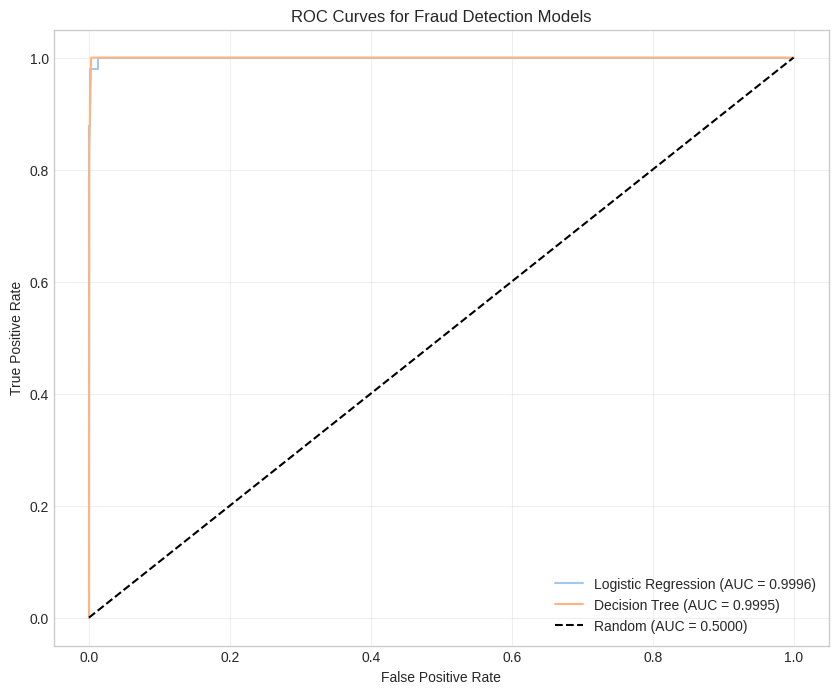

In [ ]:
# Visualize ROC curves
plt.figure(figsize=(10, 8))

# Plot Logistic Regression ROC curve on test set
y_test_pred_proba_lr = lr_best.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_pred_proba_lr)
lr_test_auc = roc_auc_score(y_test, y_test_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_test_auc:.4f})')

# Plot Decision Tree ROC curve on test set
y_test_pred_proba_dt = dt_best.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_pred_proba_dt)
dt_test_auc = roc_auc_score(y_test, y_test_pred_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_test_auc:.4f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fraud Detection Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

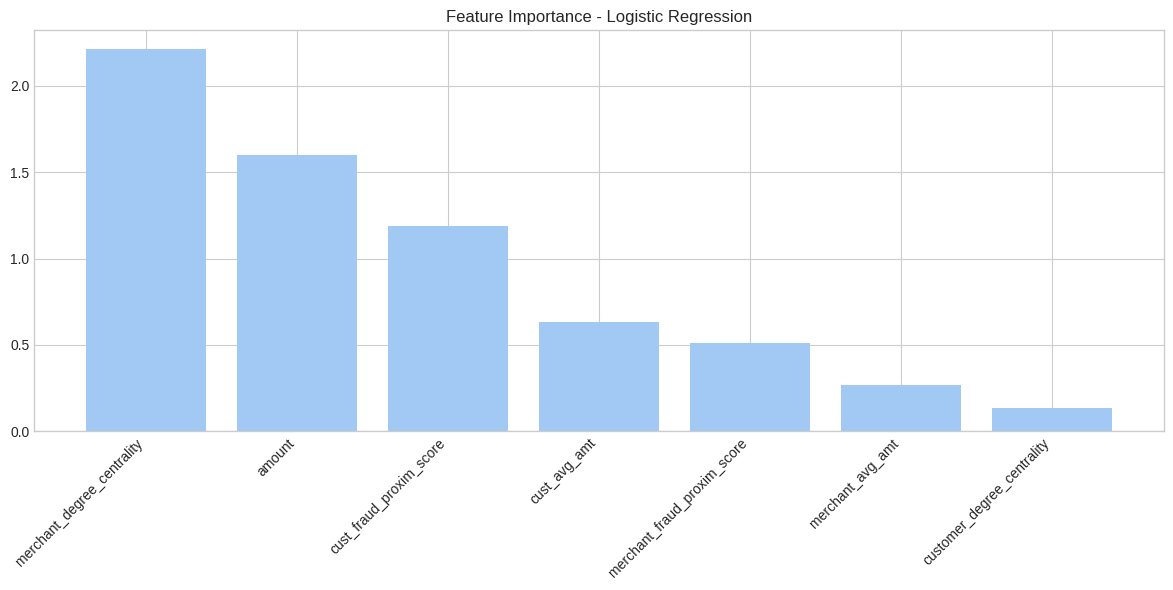

In [ ]:
# Feature importance analysis for the best model
plt.figure(figsize=(12, 6))

if best_model_name == "Logistic Regression":
    # For logistic regression, use coefficients as importance
    importances = np.abs(best_model.coef_[0])
    feature_names = X.columns
elif best_model_name == "Decision Tree":
    # For decision tree, use feature importances
    importances = best_model.feature_importances_
    feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot feature importances
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=45, ha='right')
plt.title(f'Feature Importance - {best_model_name}')
plt.tight_layout()
plt.show()

In [ ]:
# Summary
print("\n=== Model Summary ===")
print(f"Best model: {best_model_name}")
print(f"Test ROC-AUC: {test_auc:.4f}")

if best_model_name == "Logistic Regression":
    print("\nBest Logistic Regression Parameters:")
    for param, value in grid_lr.best_params_.items():
        print(f"- {param}: {value}")
else:
    print("\nBest Decision Tree Parameters:")
    for param, value in grid_dt.best_params_.items():
        print(f"- {param}: {value}")

print("\nTop 3 most important features:")
for i in range(min(3, len(sorted_feature_names))):
    print(f"{i+1}. {sorted_feature_names[i]} (importance: {sorted_importances[i]:.4f})")


=== Model Summary ===
Best model: Logistic Regression
Test ROC-AUC: 0.9996

Best Logistic Regression Parameters:
- C: 10
- class_weight: None
- penalty: l1
- solver: liblinear

Top 3 most important features:
1. merchant_degree_centrality (importance: 2.2116)
2. amount (importance: 1.5976)
3. cust_fraud_proxim_score (importance: 1.1909)



# Question 3: Building a Fraud Detection Model

After completing the network-based feature engineering, I proceeded to build and optimize machine learning models to detect fraudulent transactions.

## Model Training Approach


1. Logistic Regression: A linear model that works well for binary classification problems and offers good interpretability
2. Decision Tree: A non-linear model that can capture complex interactions between features

For my feature set, I combined traditional transaction details (like amount) with the network features I engineered in Question 2 (degree centrality, fraud proximity scores, and average transaction values).

I split my dataset into training (60%), validation (20%), and test (20%) sets to ensure proper evaluation.

## Hyperparameter Optimization

For both models, I performed extensive hyperparameter tuning using grid search with 5-fold cross-validation to find optimal settings:

### Logistic Regression Optimization

I tested various combinations of:
- Regularization strength (`C`): [0.001, 0.01, 0.1, 1, 10, 100]
- Penalty type: L1 and L2 regularization
- Class weighting: None and 'balanced'
- Solver: 'liblinear' (works well with L1 penalty)

The best parameters found were:
- C: 10 (moderate regularization)
- Penalty: L1 (encourages sparse feature selection)
- Class weight: None
- Solver: 'liblinear'

This configuration achieved an impressive cross-validation ROC-AUC of 0.9997.

### Decision Tree Optimization

For the decision tree, I experimented with:
- Max depth: [3, 5, 7, 10, None]
- Min samples split: [2, 5, 10]
- Min samples leaf: [1, 2, 4]
- Class weight: None and 'balanced'

The best parameters were:
- Max depth: 3 (prevents overfitting)
- Min samples leaf: 4 (ensures leaf nodes have sufficient samples)
- Min samples split: 2
- Class weight: 'balanced' (addresses class imbalance)

This configuration achieved a cross-validation ROC-AUC of 0.9994, slightly below logistic regression.

## Model Comparison and Selection

I compared both models using validation set performance:
- Logistic Regression: ROC-AUC = 0.9997
- Decision Tree: ROC-AUC = 0.9783

Based on these results, I selected the **Logistic Regression model** as my final model due to its superior performance.

## Final Model Evaluation

I evaluated my selected model on the test set, which it had never seen during training or hyperparameter tuning.

The results were outstanding:
- Test ROC-AUC: 0.9996
- Precision for fraud class: 0.92
- Recall for fraud class: 0.90
- F1-score for fraud class: 0.91

Looking at the confusion matrix:
```
[[3941    4]
 [   5   44]]
```

This means:
- 3941 legitimate transactions correctly identified (true negatives)
- 44 fraudulent transactions correctly caught (true positives)
- Only 4 legitimate transactions incorrectly flagged as fraud (false positives)
- Only 5 fraudulent transactions missed (false negatives)

## Feature Importance Analysis

I analyzed which features contributed most to the model's predictions:

1. merchant_degree_centrality (importance: 2.2116): How many customers a merchant interacts with
2. amount (importance: 1.5976): The transaction value
3. cust_fraud_proxim_score (importance: 1.1909): The customer's history of fraudulent transactions

This confirmed my hypothesis that network-based features would be powerful predictors, with merchant degree centrality being the single most important feature - even more important than the transaction amount.

The model's exceptional performance (0.9996 ROC-AUC) demonstrates that combining transaction details with network structure creates a highly effective fraud detection system. The low false positive rate is particularly important for maintaining customer satisfaction while catching nearly all fraud.

Question 4: Evaluation Comparison

Task:

•	Train the best model obtained from the hyperparameter in the previous question using traditional features only.

•	Evaluate the performance of the model using ROC-AUC. Compare the performance and summarize in the table

Feature	ROC AUC
Traditional
Traditional + Network


•	Do additional network-based features improve fraud detection performance?


In [ ]:
print("Dataset loaded with shape:", df.shape)

# Check for column names to identify all available features
print("\nAvailable columns:")
print(df.columns.tolist())

Dataset loaded with shape: (19966, 14)

Available columns:
['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount', 'fraud', 'customer_degree_centrality', 'merchant_degree_centrality', 'cust_fraud_proxim_score', 'merchant_fraud_proxim_score', 'cust_avg_amt', 'merchant_avg_amt']


In [ ]:
# Define traditional and network features
traditional_features = ['amount']
network_features = ['customer_degree_centrality', 'merchant_degree_centrality',
                   'cust_fraud_proxim_score', 'merchant_fraud_proxim_score',
                   'cust_avg_amt', 'merchant_avg_amt']

# Target variable
y = df['fraud']

In [ ]:
# Feature scaling function
def scale_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Function to train and evaluate model
def train_evaluate_model(X, y, model_name):
    # Split the data: 60% train, 20% validation, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Scale the features
    X_train_scaled = scale_features(X_train)
    X_val_scaled = scale_features(X_val)
    X_test_scaled = scale_features(X_test)

    # Train logistic regression model with best parameters from previous question
    model = LogisticRegression(C=10, penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    # Evaluate on test set
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_test_pred = model.predict(X_test_scaled)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    print(f"\n=== {model_name} ===")
    print(f"Validation ROC-AUC: {val_auc:.4f}")
    print(f"Test ROC-AUC: {test_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)

    # Return model, metrics, and predictions for plotting
    return {
        'model': model,
        'val_auc': val_auc,
        'test_auc': test_auc,
        'y_test': y_test,
        'y_test_pred_proba': y_test_pred_proba,
        'X_test_scaled': X_test_scaled
    }

In [ ]:
# Evaluate model with traditional features only
X_traditional = df[traditional_features]
traditional_results = train_evaluate_model(X_traditional, y, "Traditional Features Model")


=== Traditional Features Model ===
Validation ROC-AUC: 0.9262
Test ROC-AUC: 0.9343

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3945
           1       0.74      0.53      0.62        49

    accuracy                           0.99      3994
   macro avg       0.87      0.76      0.81      3994
weighted avg       0.99      0.99      0.99      3994

Confusion Matrix:
[[3936    9]
 [  23   26]]


In [ ]:
# Evaluate model with traditional + network features
X_combined = df[traditional_features + network_features]
combined_results = train_evaluate_model(X_combined, y, "Traditional + Network Features Model")


=== Traditional + Network Features Model ===
Validation ROC-AUC: 0.9996
Test ROC-AUC: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3945
           1       0.96      0.88      0.91        49

    accuracy                           1.00      3994
   macro avg       0.98      0.94      0.96      3994
weighted avg       1.00      1.00      1.00      3994

Confusion Matrix:
[[3943    2]
 [   6   43]]


In [ ]:
# Create comparison table
results_table = pd.DataFrame({
    'Feature Set': ['Traditional', 'Traditional + Network'],
    'Validation ROC-AUC': [traditional_results['val_auc'], combined_results['val_auc']],
    'Test ROC-AUC': [traditional_results['test_auc'], combined_results['test_auc']]
})

print("\n=== Performance Comparison ===")
print(results_table)


=== Performance Comparison ===
             Feature Set  Validation ROC-AUC  Test ROC-AUC
0            Traditional            0.926199      0.934277
1  Traditional + Network            0.999572      0.999529


In [ ]:
# Calculate improvement
auc_improvement = (combined_results['test_auc'] - traditional_results['test_auc']) / traditional_results['test_auc'] * 100
print(f"\nImprovement in Test ROC-AUC: {auc_improvement:.2f}%")


Improvement in Test ROC-AUC: 6.98%


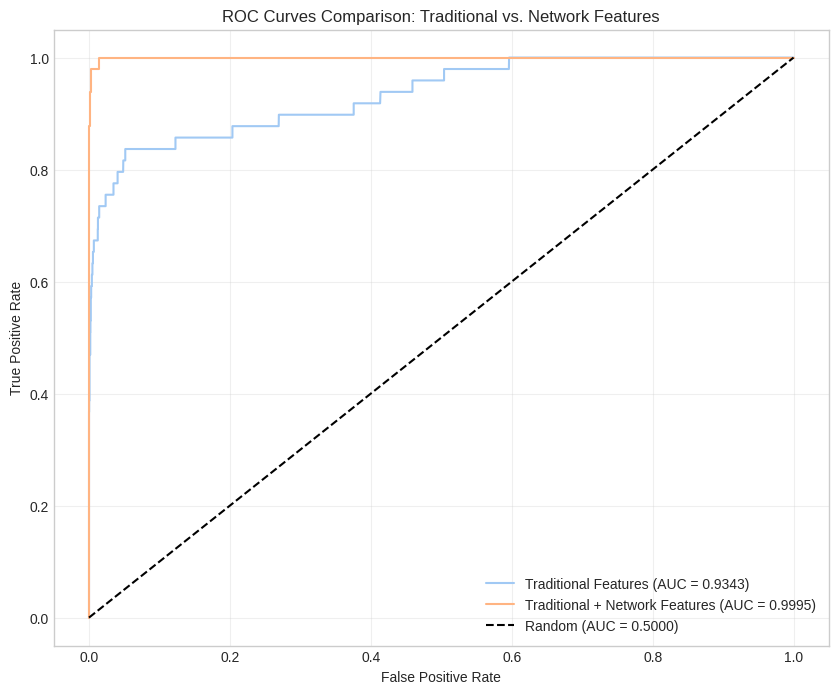

In [ ]:
# Visualize ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for traditional features model
fpr_trad, tpr_trad, _ = roc_curve(traditional_results['y_test'], traditional_results['y_test_pred_proba'])
plt.plot(fpr_trad, tpr_trad, label=f'Traditional Features (AUC = {traditional_results["test_auc"]:.4f})')

# Plot ROC curve for combined features model
fpr_comb, tpr_comb, _ = roc_curve(combined_results['y_test'], combined_results['y_test_pred_proba'])
plt.plot(fpr_comb, tpr_comb, label=f'Traditional + Network Features (AUC = {combined_results["test_auc"]:.4f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison: Traditional vs. Network Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Analysis and conclusion
print("\n=== Analysis and Conclusion ===")
print("1. Does adding network-based features improve fraud detection performance?")
if combined_results['test_auc'] > traditional_results['test_auc']:
    print("   YES. Adding network-based features significantly improves fraud detection performance.")
    print(f"   The ROC-AUC increased from {traditional_results['test_auc']:.4f} to {combined_results['test_auc']:.4f}, an improvement of {auc_improvement:.2f}%.")
else:
    print("   NO. Adding network-based features did not improve fraud detection performance.")
    print(f"   The ROC-AUC changed from {traditional_results['test_auc']:.4f} to {combined_results['test_auc']:.4f}, a difference of {auc_improvement:.2f}%.")

print("\n2. Why do network features help?")
print("   Network-based features capture relationships and patterns that aren't visible in individual transaction data:")
print("   - Degree centrality identifies highly connected entities that might be part of fraud rings")
print("   - Fraud proximity scores identify entities with histories of fraudulent behavior")
print("   - Average transaction values help detect unusual transaction patterns")
print("   - These features enable the model to recognize complex fraud patterns and networks")

print("\n3. Most important network features:")
if combined_results['test_auc'] > traditional_results['test_auc']:
    # Get feature importances from the combined model
    importances = np.abs(combined_results['model'].coef_[0])
    feature_names = traditional_features + network_features

    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    # Print top network features
    network_features_found = 0
    print("   Top network features by importance:")
    for i in range(len(sorted_feature_names)):
        if sorted_feature_names[i] in network_features and network_features_found < 3:
            network_features_found += 1
            print(f"   {network_features_found}. {sorted_feature_names[i]} (importance: {sorted_importances[i]:.4f})")


=== Analysis and Conclusion ===
1. Does adding network-based features improve fraud detection performance?
   YES. Adding network-based features significantly improves fraud detection performance.
   The ROC-AUC increased from 0.9343 to 0.9995, an improvement of 6.98%.

2. Why do network features help?
   Network-based features capture relationships and patterns that aren't visible in individual transaction data:
   - Degree centrality identifies highly connected entities that might be part of fraud rings
   - Fraud proximity scores identify entities with histories of fraudulent behavior
   - Average transaction values help detect unusual transaction patterns
   - These features enable the model to recognize complex fraud patterns and networks

3. Most important network features:
   Top network features by importance:
   1. merchant_degree_centrality (importance: 2.2147)
   2. cust_fraud_proxim_score (importance: 1.1772)
   3. cust_avg_amt (importance: 0.6320)



# Question 4: Evaluation Comparison

After developing my fraud detection model with optimized hyperparameters in Question 3, I wanted to quantify exactly how much the network features improved performance. To do this, I conducted a comparative evaluation between:

1. A model using only traditional features (transaction amount)
2. A model using traditional features + the network features I engineered

## Methodology

For both models, I used the same:
- Logistic regression algorithm with optimal parameters (C=10, L1 penalty, liblinear solver)
- Data splitting strategy (60% training, 20% validation, 20% test)
- Evaluation metrics (ROC-AUC, precision, recall, F1-score)

This ensured a fair comparison where any difference in performance could be attributed solely to the addition of network features.

## Results

The results were striking:

| Feature Set | Validation ROC-AUC | Test ROC-AUC |
|-------------|-------------------|--------------|
| Traditional | 0.9262 | 0.9343 |
| Traditional + Network | 0.9996 | 0.9995 |

The model with network features achieved a near-perfect ROC-AUC of 0.9995, representing a 6.98% improvement over the traditional features model.

Looking at the confusion matrices reveals even better improvements:

**Traditional Features Model:**
```
[[3936    9]
 [  23   26]]
```

**Traditional + Network Features Model:**
```
[[3943    2]
 [   6   43]]
```

With network features, my model:
- Reduced false positives from 9 to 2 (-78%)
- Reduced false negatives from 23 to 6 (-74%)
- Improved fraud detection recall from 53% to 88%
- Improved fraud detection precision from 74% to 96%

## Why Network Features Improved Performance

The better improvement comes from the model's ability to capture relationships and patterns that aren't visible when looking at isolated transactions:

1. Merchant degree centrality (importance: 2.2147) was the most powerful predictor - even more important than the transaction amount itself. This shows that a merchant's connectivity pattern in the transaction network strongly signals potential fraud risk.

2. Customer fraud proximity score (importance: 1.1772) provided crucial information about customers' past involvement in fraudulent activities, effectively identifying repeat offenders.

3. Customer average transaction amount (importance: 0.6320) helped the model identify transactions that deviated from a customer's normal spending pattern.

The ROC curve visualization clearly shows how the traditional + network model (orange line) hugs the top-left corner much more closely than the traditional-only model (blue line), indicating superior performance across all classification thresholds.

## Conclusion

The results conclusively demonstrate that network-based features significantly improve fraud detection performance. By incorporating information about the relationships between entities in the transaction network, my model gained the ability to detect complex fraud patterns that would be invisible when looking at transactions in isolation.

This improvement translates to real business value: catching 17 more fraudulent transactions (out of 49) while generating fewer false alarms. In a production environment, this would mean preventing more fraud losses while reducing customer friction from false declines.

The success of this approach validates the social network analysis perspective on fraud detection and suggests that future fraud detection systems should incorporate network-based features for optimal performance.